In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Air.csv')
df.head()

,index,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,Adjusted Activity Type Code,Adjusted Passenger Count,Year,Month
0,0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271,Deplaned,27271,2005,July
1,1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131,Enplaned,29131,2005,July
2,2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415,Thru / Transit * 2,10830,2005,July
3,3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156,Deplaned,35156,2005,July
4,4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090,Enplaned,34090,2005,July


In [ ]:
df['Activity Period'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'])

monthly_data = df.groupby(['Activity Period'])['Adjusted Passenger Count'].sum().reset_index()

monthly_data.columns = ['Date', 'Passenger_Count']

monthly_data.set_index('Date', inplace=True)

print(monthly_data.head())


            Passenger_Count
Date                       
2005-07-01          3254797
2005-08-01          3224118
2005-09-01          2764519
2005-10-01          2798480
2005-11-01          2638631


In [ ]:
df.isnull().sum()

,0
index,0
Activity Period,0
Operating Airline,0
Operating Airline IATA Code,54
Published Airline,0
Published Airline IATA Code,54
GEO Summary,0
GEO Region,0
Activity Type Code,0
Price Category Code,0


In [ ]:
data_cleaned = df.dropna()
data_cleaned.isnull().sum()

,0
index,0
Activity Period,0
Operating Airline,0
Operating Airline IATA Code,0
Published Airline,0
Published Airline IATA Code,0
GEO Summary,0
GEO Region,0
Activity Type Code,0
Price Category Code,0


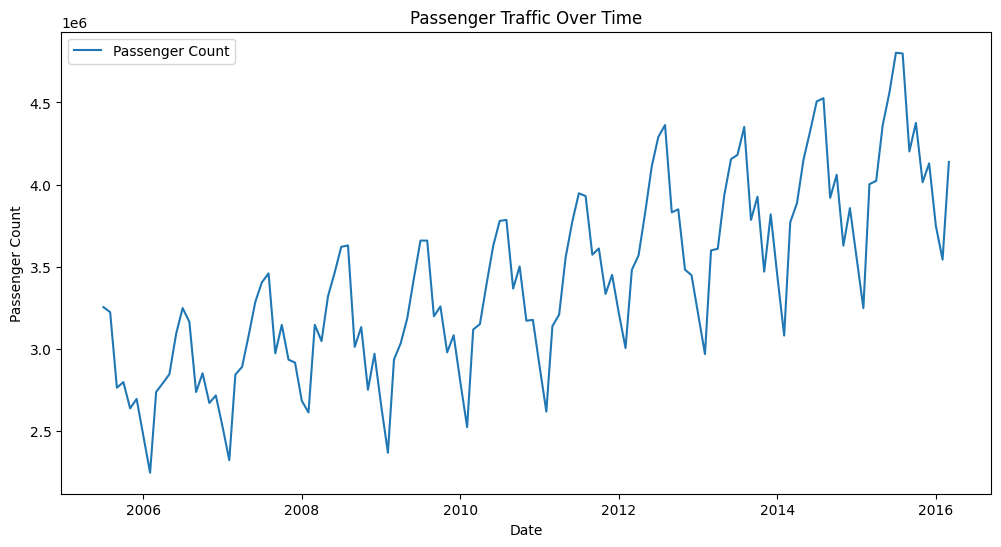

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['Passenger_Count'], label='Passenger Count')
plt.title("Passenger Traffic Over Time")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()


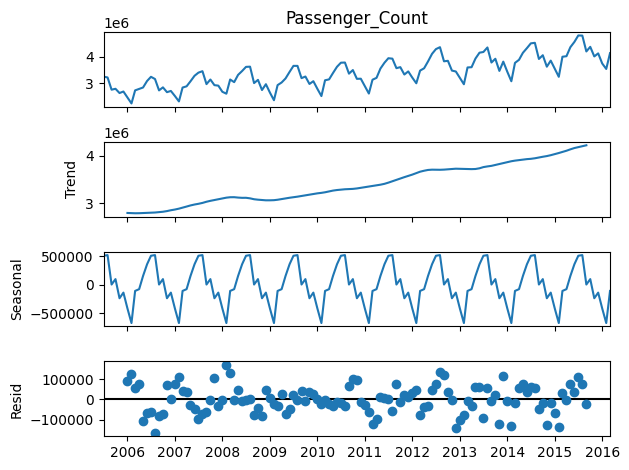

In [ ]:
decomposition = seasonal_decompose(monthly_data['Passenger_Count'], model='additive', period=12)
decomposition.plot()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_data['Passenger_Count'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ADF Statistic: 0.22374118311880942
p-value: 0.9735621668747095
The time series is not stationary.


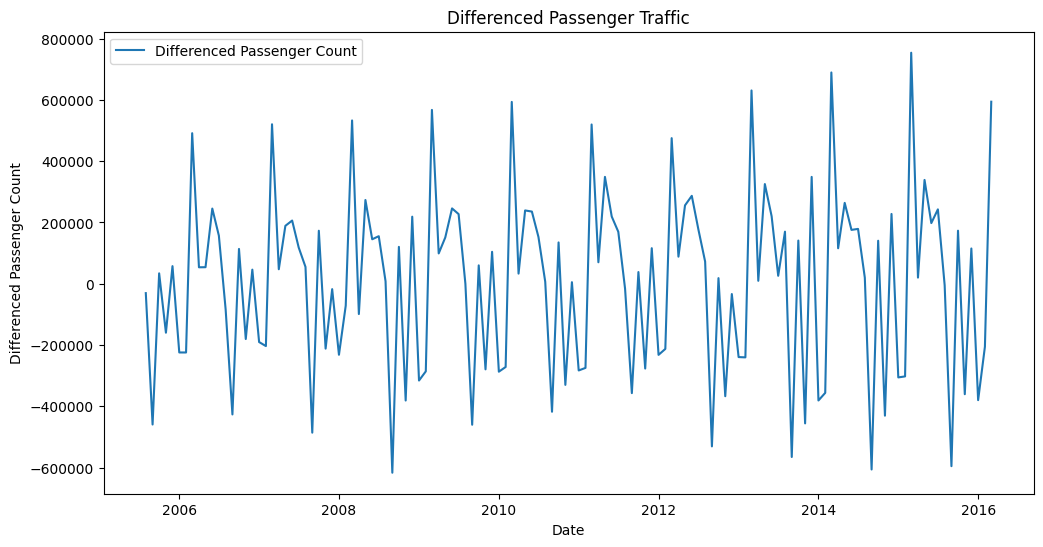

In [ ]:

monthly_data['Diff'] = monthly_data['Passenger_Count'].diff()
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['Diff'].dropna(), label='Differenced Passenger Count')
plt.title("Differenced Passenger Traffic")
plt.xlabel("Date")
plt.ylabel("Differenced Passenger Count")
plt.legend()
plt.show()


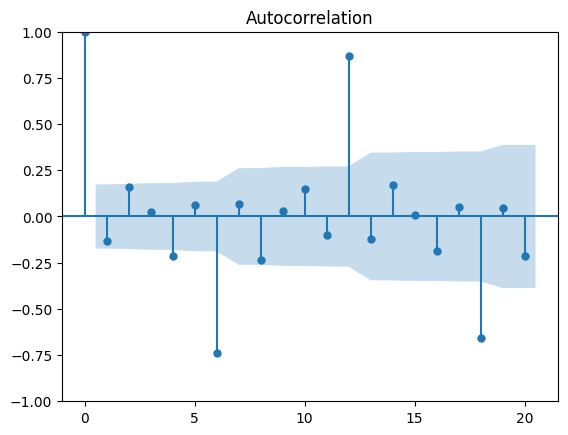

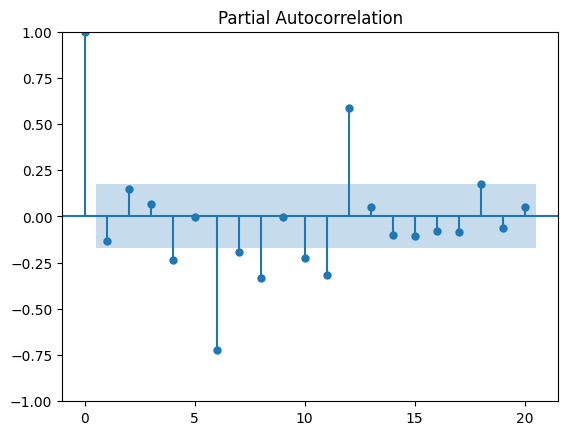

In [ ]:
plot_acf(monthly_data['Diff'].dropna(), lags=20)
plt.show()

plot_pacf(monthly_data['Diff'].dropna(), lags=20)
plt.show()


In [ ]:

train = monthly_data.iloc[:-12]
test = monthly_data.iloc[-12:]


2015-04-01    3.949386e+06
2015-05-01    3.950740e+06
2015-06-01    3.950705e+06
2015-07-01    3.950706e+06
2015-08-01    3.950706e+06
2015-09-01    3.950706e+06
2015-10-01    3.950706e+06
2015-11-01    3.950706e+06
2015-12-01    3.950706e+06
2016-01-01    3.950706e+06
2016-02-01    3.950706e+06
2016-03-01    3.950706e+06
Freq: MS, Name: predicted_mean, dtype: float64


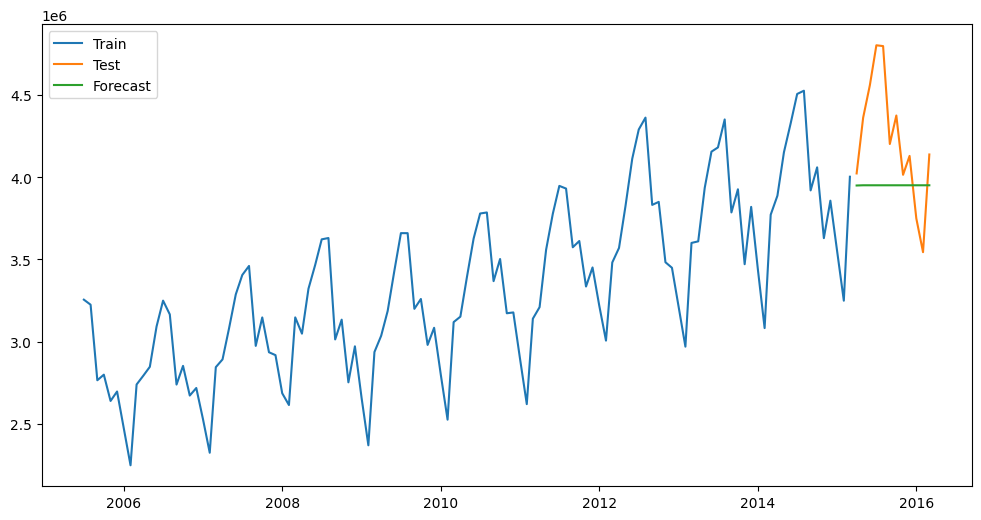

MAE: 375438.00965611805
RMSE: 457154.9378620941


In [ ]:
model = ARIMA(train['Passenger_Count'], order=(1, 1, 1))
arima_results = model.fit()

forecast = arima_results.forecast(steps=12)
print(forecast)

plt.figure(figsize=(12, 6))
plt.plot(train['Passenger_Count'], label='Train')
plt.plot(test['Passenger_Count'], label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()

mae = mean_absolute_error(test['Passenger_Count'], forecast)
rmse = np.sqrt(mean_squared_error(test['Passenger_Count'], forecast))
print("MAE:", mae)
print("RMSE:", rmse)


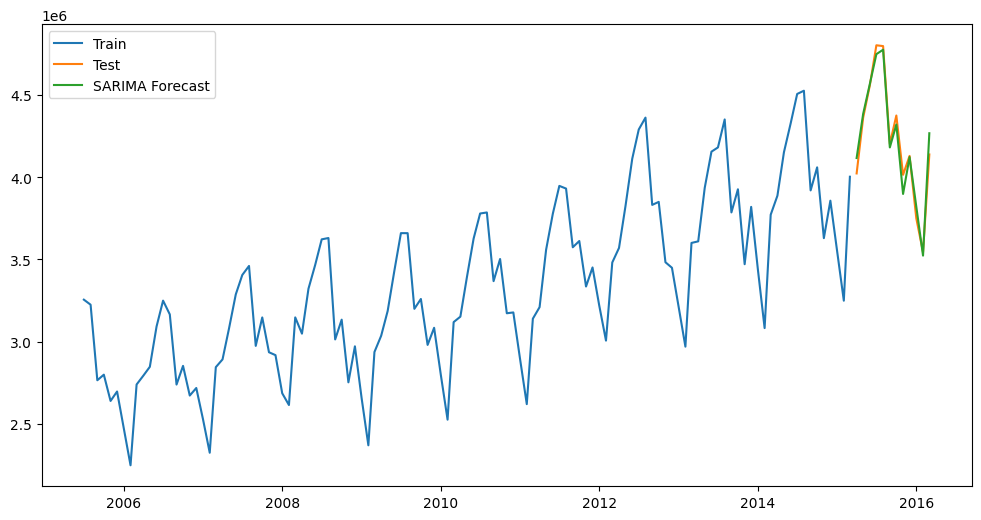

SARIMA MAE: 51794.62498170696
SARIMA RMSE: 65842.8320498605


In [ ]:
sarima_model = SARIMAX(train['Passenger_Count'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()

sarima_forecast = sarima_results.forecast(steps=12)

plt.figure(figsize=(12, 6))
plt.plot(train['Passenger_Count'], label='Train')
plt.plot(test['Passenger_Count'], label='Test')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.show()

mae_sarima = mean_absolute_error(test['Passenger_Count'], sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test['Passenger_Count'], sarima_forecast))
print("SARIMA MAE:", mae_sarima)
print("SARIMA RMSE:", rmse_sarima)


In [ ]:
import joblib
joblib.dump(sarima_results, 'sarima_model.pkl')

loaded_model = joblib.load('sarima_model.pkl')
future_forecast = loaded_model.forecast(steps=12)
print(future_forecast)


2015-04-01    4.116507e+06
2015-05-01    4.384609e+06
2015-06-01    4.567780e+06
2015-07-01    4.748456e+06
2015-08-01    4.775349e+06
2015-09-01    4.180852e+06
2015-10-01    4.320235e+06
2015-11-01    3.897957e+06
2015-12-01    4.122387e+06
2016-01-01    3.820414e+06
2016-02-01    3.522806e+06
2016-03-01    4.267271e+06
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
!pip install pmdarima==2.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.4 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=87.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=299589.076, Time=0.64 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=298775.920, Time=4.97 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=297032.306, Time=9.81 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=299587.076, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=297030.908, Time=2.96 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=297032.311, Time=9.20 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=297034.307, Time=11.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=21.93 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=16.54 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=298779.333, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=28.23 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=297028.904, Time=1.46 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=297030.307, Time=6.20 sec
 ARIMA(0,1,1)(

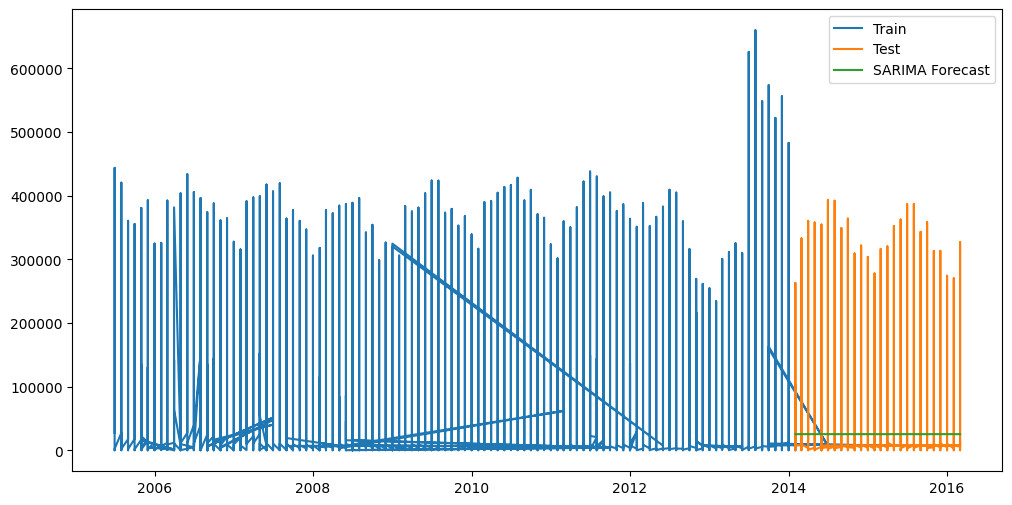

In [ ]:
!pip install pmdarima==2.0.3
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

df = pd.read_csv('Air.csv')

df['Activity Period'] = pd.to_datetime(df['Activity Period'], format='%Y%m')
df.set_index('Activity Period', inplace=True)

train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

auto_arima_model = auto_arima(train['Passenger Count'],
                              seasonal=True, m=12,
                              trace=True, error_action='ignore',
                              suppress_warnings=True, stepwise=True)

auto_arima_results = auto_arima_model.fit(train['Passenger Count'])

auto_arima_forecast = auto_arima_results.predict(n_periods=len(test))

mae_sarima = mean_absolute_error(test['Passenger Count'], auto_arima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test['Passenger Count'], auto_arima_forecast))
print("SARIMA MAE:", mae_sarima)
print("SARIMA RMSE:", rmse_sarima)

plt.figure(figsize=(12, 6))
plt.plot(train['Passenger Count'], label='Train')
plt.plot(test['Passenger Count'], label='Test')
plt.plot(test.index, auto_arima_forecast, label='SARIMA Forecast')
plt.legend()
plt.show()

In [ ]:
!pip install prophet pandas matplotlib



Original column names: Index(['index', 'Operating Airline', 'Operating Airline IATA Code',
       'Published Airline', 'Published Airline IATA Code', 'GEO Summary',
       'GEO Region', 'Activity Type Code', 'Price Category Code', 'Terminal',
       'Boarding Area', 'Passenger Count', 'Adjusted Activity Type Code',
       'Adjusted Passenger Count', 'Year', 'Month'],
      dtype='object')


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyuufyc_j/g7saq610.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyuufyc_j/hy9ooed7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67092', 'data', 'file=/tmp/tmpyuufyc_j/g7saq610.json', 'init=/tmp/tmpyuufyc_j/hy9ooed7.json', 'output', 'file=/tmp/tmpyuufyc_j/prophet_modelq98pyl1d/prophet_model-20241121064821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:48:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:48:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


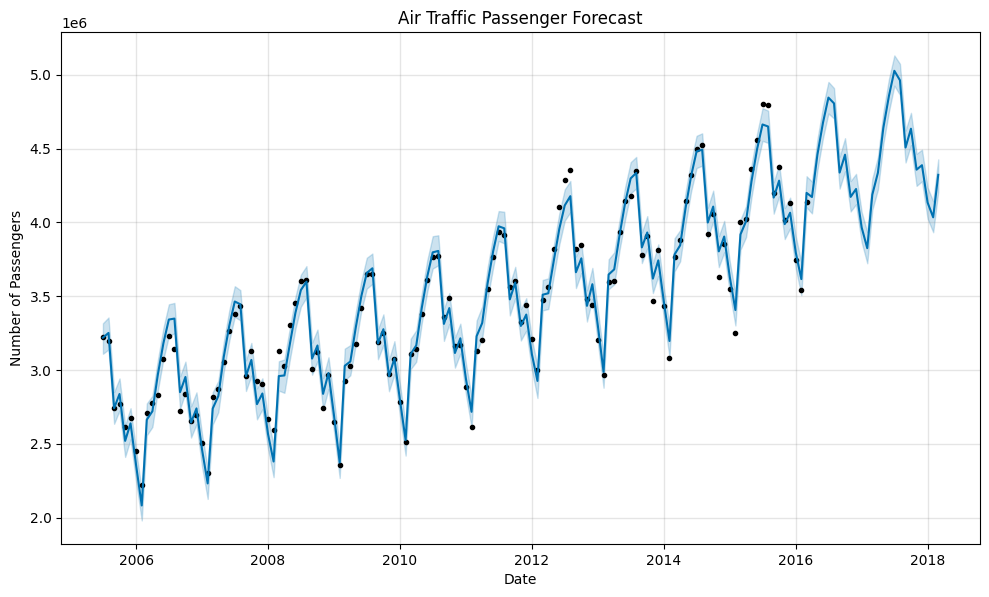

            ds          yhat    yhat_lower    yhat_upper
148 2017-10-31  4.357377e+06  4.247306e+06  4.465157e+06
149 2017-11-30  4.387542e+06  4.278394e+06  4.492685e+06
150 2017-12-31  4.135039e+06  4.026148e+06  4.236282e+06
151 2018-01-31  4.034388e+06  3.933398e+06  4.143112e+06
152 2018-02-28  4.322348e+06  4.207499e+06  4.427010e+06


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


print("Original column names:", df.columns)

df.columns = df.columns.str.strip()

df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')

monthly_passengers = df.groupby('Date')['Passenger Count'].sum().reset_index()

monthly_passengers.rename(columns={'Date': 'ds', 'Passenger Count': 'y'}, inplace=True)

model = Prophet()

model.fit(monthly_passengers)

future = model.make_future_dataframe(periods=12*2, freq='M')

forecast = model.predict(future)

model.plot(forecast)
plt.title('Air Traffic Passenger Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyuufyc_j/ozt4_3w8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyuufyc_j/3b72rr1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31018', 'data', 'file=/tmp/tmpyuufyc_j/ozt4_3w8.json', 'init=/tmp/tmpyuufyc_j/3b72rr1t.json', 'output', 'file=/tmp/tmpyuufyc_j/prophet_modelu5r8znf_/prophet_model-20241121064822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:48:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:48:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Original column names: Index(['index', 'Operating Airline', 'Operating Airline IATA Code',
       'Published Airline', 'Published Airline IATA Code', 'GEO Summary',
       'GEO Region', 'Activity Type Code', 'Price Category Code', 'Terminal',
       'Boarding Area', 'Passenger Count', 'Adjusted Activity Type Code',
       'Adjusted Passenger Count', 'Year', 'Month', 'Date'],
      dtype='object')


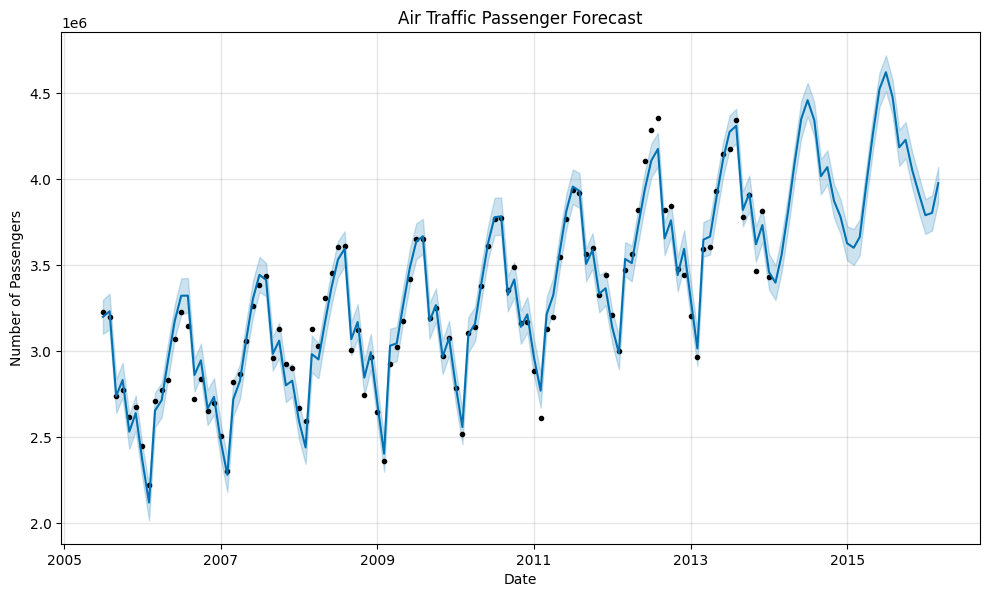

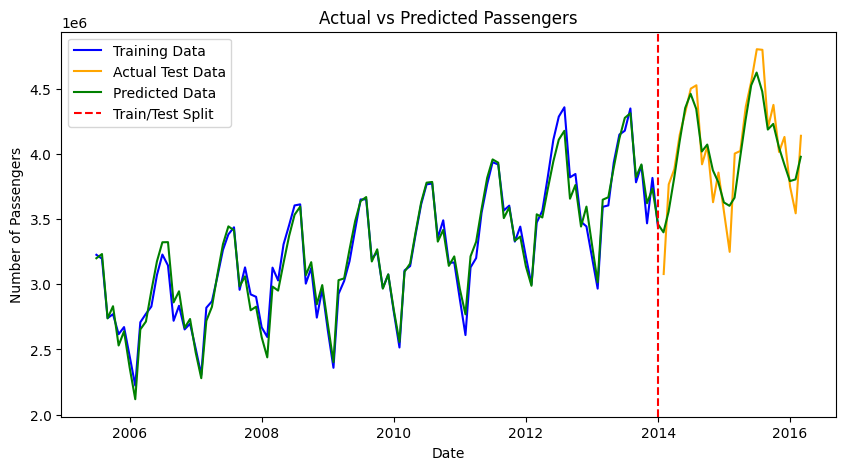

            ds          yhat    yhat_lower    yhat_upper
103 2014-01-31  3.398025e+06  3.296920e+06  3.497844e+06
104 2014-02-28  3.555349e+06  3.454116e+06  3.661242e+06
105 2014-03-31  3.813561e+06  3.709760e+06  3.909138e+06
106 2014-04-30  4.091884e+06  3.988577e+06  4.183918e+06
107 2014-05-31  4.350380e+06  4.237082e+06  4.455649e+06
108 2014-06-30  4.459602e+06  4.366484e+06  4.561040e+06
109 2014-07-31  4.343732e+06  4.246741e+06  4.447867e+06
110 2014-08-31  4.017344e+06  3.910617e+06  4.116739e+06
111 2014-09-30  4.070406e+06  3.972124e+06  4.167644e+06
112 2014-10-31  3.873719e+06  3.775594e+06  3.972230e+06
113 2014-11-30  3.782463e+06  3.683350e+06  3.883659e+06
114 2014-12-31  3.627181e+06  3.528041e+06  3.726520e+06
115 2015-01-31  3.601062e+06  3.500622e+06  3.708960e+06
116 2015-02-28  3.663265e+06  3.556918e+06  3.765814e+06
117 2015-03-31  3.972902e+06  3.876713e+06  4.070042e+06
118 2015-04-30  4.260165e+06  4.161745e+06  4.361089e+06
119 2015-05-31  4.524448e+06  4

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

print("Original column names:", df.columns)

df.columns = df.columns.str.strip()

df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')

monthly_passengers = df.groupby('Date')['Passenger Count'].sum().reset_index()

monthly_passengers.rename(columns={'Date': 'ds', 'Passenger Count': 'y'}, inplace=True)

split_index = int(len(monthly_passengers) * 0.8)

train = monthly_passengers[:split_index]
test = monthly_passengers[split_index:]

model = Prophet()

model.fit(train)

future = model.make_future_dataframe(periods=len(test), freq='M')

forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Air Traffic Passenger Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')

plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.plot(test['ds'], test['y'], label='Actual Test Data', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Data', color='green')
plt.axvline(x=train['ds'].iloc[-1], color='red', linestyle='--', label='Train/Test Split')
plt.title('Actual vs Predicted Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test)))

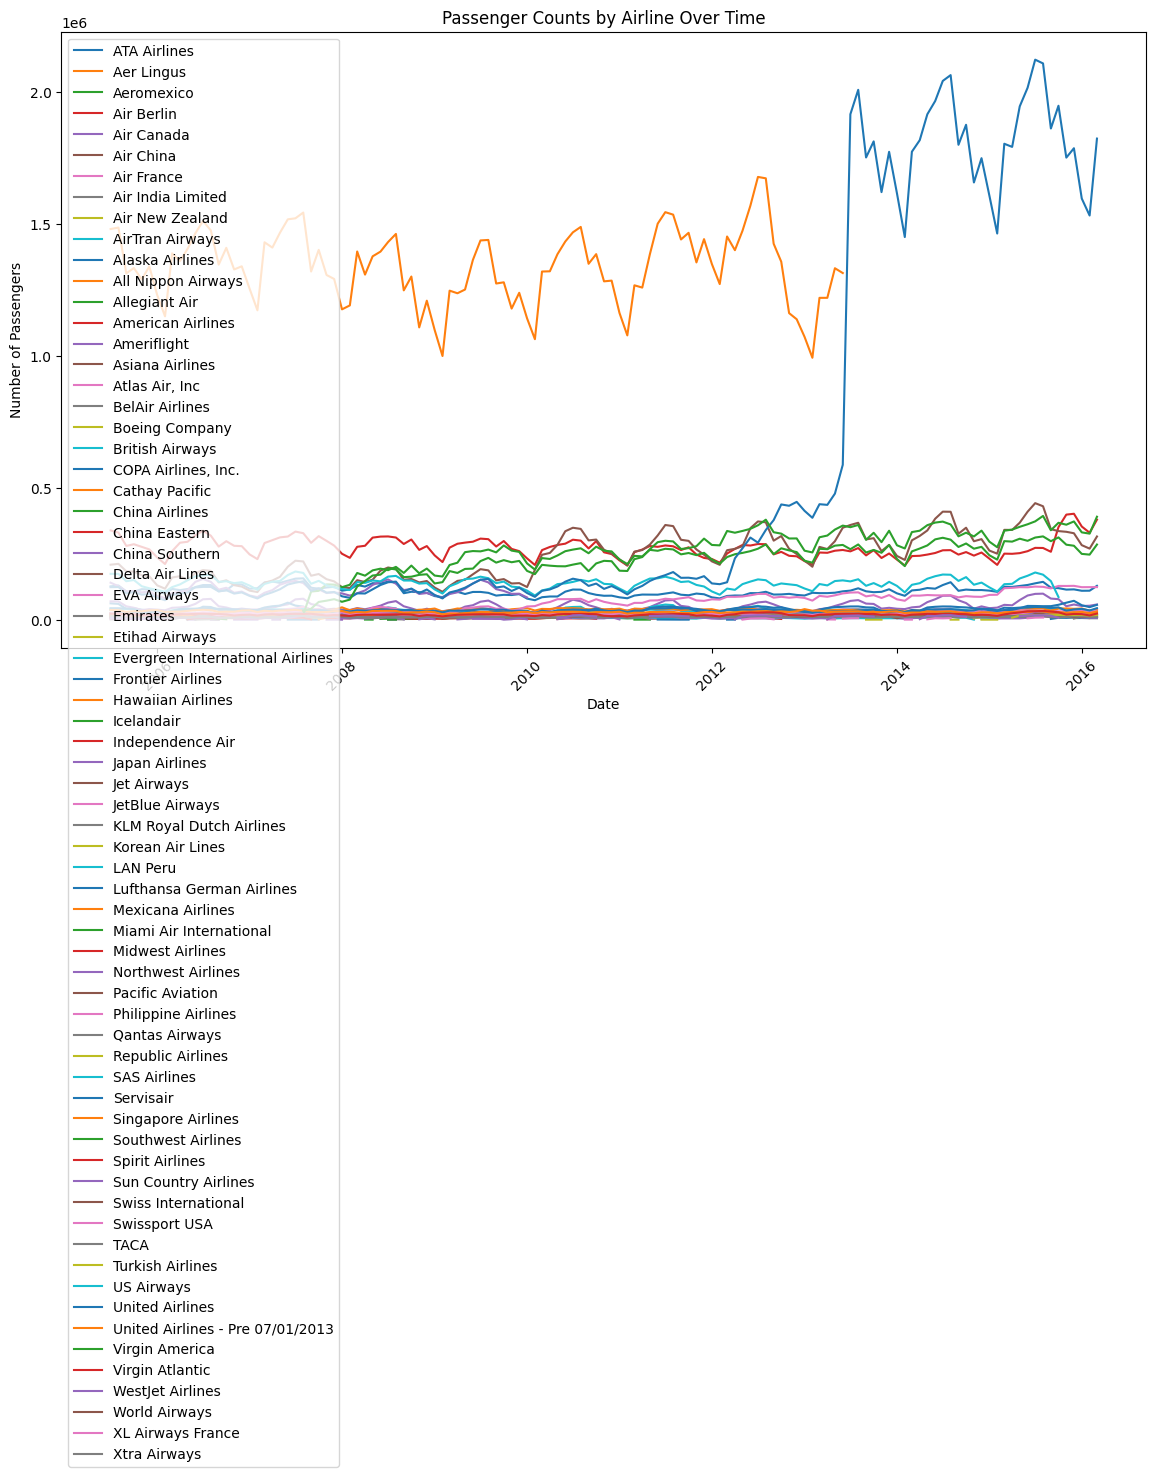

Published Airline  ATA Airlines  Aer Lingus  Aeromexico  Air Berlin  \
Date                                                                  
2005-07-01              61817.0         NaN         NaN         NaN   
2005-08-01              59719.0         NaN         NaN         NaN   
2005-09-01              40294.0         NaN         NaN         NaN   
2005-10-01              43435.0         NaN         NaN         NaN   
2005-11-01              37710.0         NaN         NaN         NaN   
...                         ...         ...         ...         ...   
2015-11-01                  NaN      9400.0     19810.0         NaN   
2015-12-01                  NaN      8590.0     24389.0         NaN   
2016-01-01                  NaN      8390.0     22843.0         NaN   
2016-02-01                  NaN      5800.0     19003.0         NaN   
2016-03-01                  NaN     11655.0     21589.0         NaN   

Published Airline  Air Canada   Air China  Air France  Air India Limited  \


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df.columns = df.columns.str.strip()

df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')

airline_passengers = df.groupby(['Date', 'Published Airline'])['Passenger Count'].sum().reset_index()

airline_passengers_pivot = airline_passengers.pivot(index='Date', columns='Published Airline', values='Passenger Count')

plt.figure(figsize=(14, 8))
for airline in airline_passengers_pivot.columns:
    plt.plot(airline_passengers_pivot.index, airline_passengers_pivot[airline], label=airline)

plt.title('Passenger Counts by Airline Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(airline_passengers_pivot)

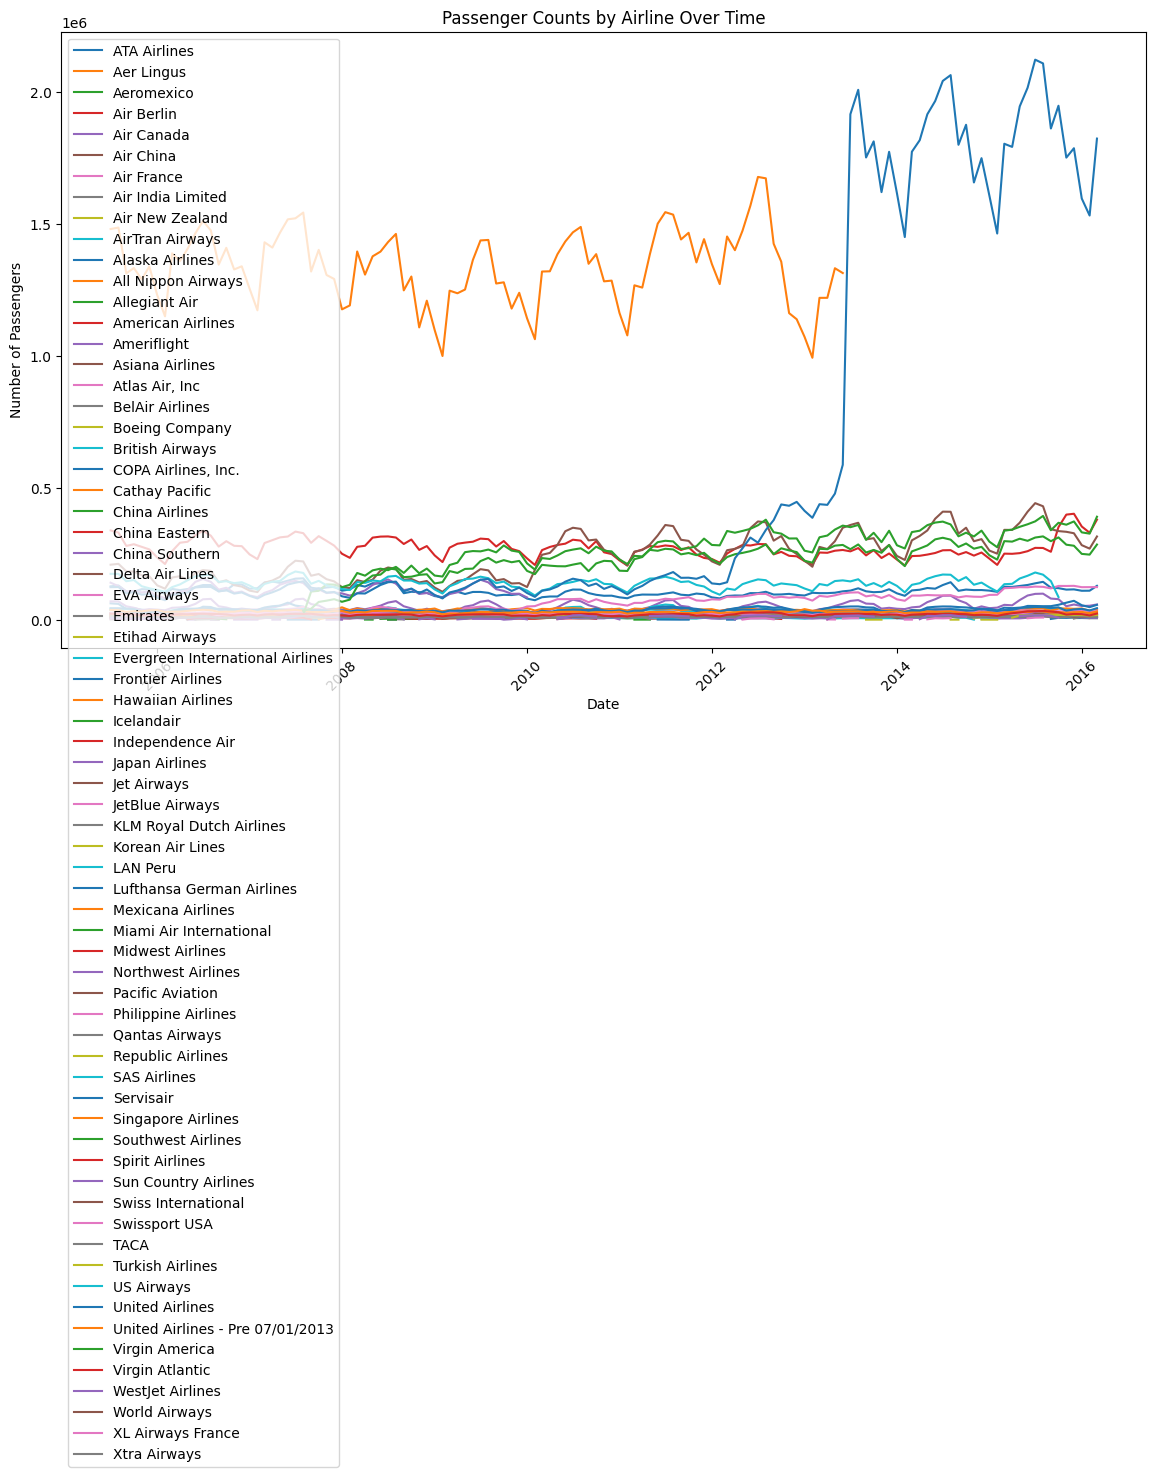

<Figure size 1200x800 with 0 Axes>

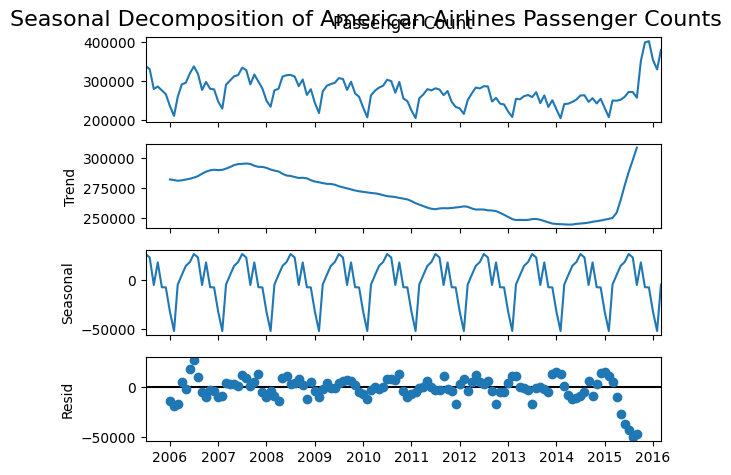

ADF Statistic: -1.340040708501049
p-value: 0.610660482765794
The time series is not stationary. Differencing may be required.


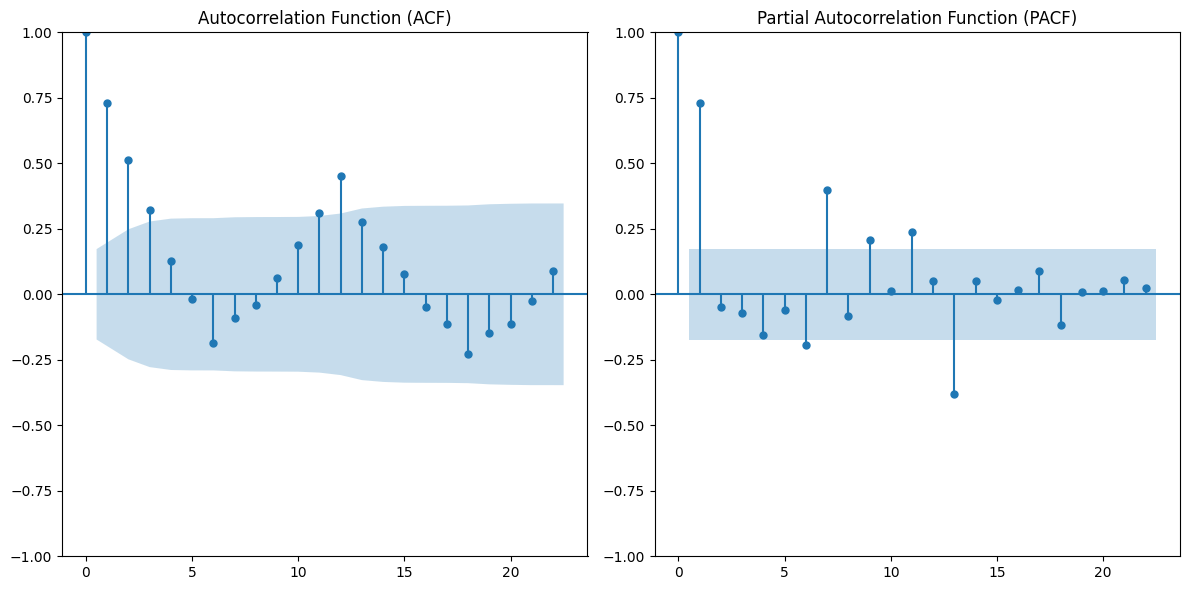

                               SARIMAX Results                                
Dep. Variable:        Passenger Count   No. Observations:                  129
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1473.599
Date:                Thu, 21 Nov 2024   AIC                           2953.199
Time:                        06:48:28   BIC                           2961.755
Sample:                    07-01-2005   HQIC                          2956.675
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7313      0.122      5.986      0.000       0.492       0.971
ma.L1         -0.8595      0.104     -8.256      0.000      -1.064      -0.655
sigma2      6.102e+08   9.94e-11   6.14e+18      0.0

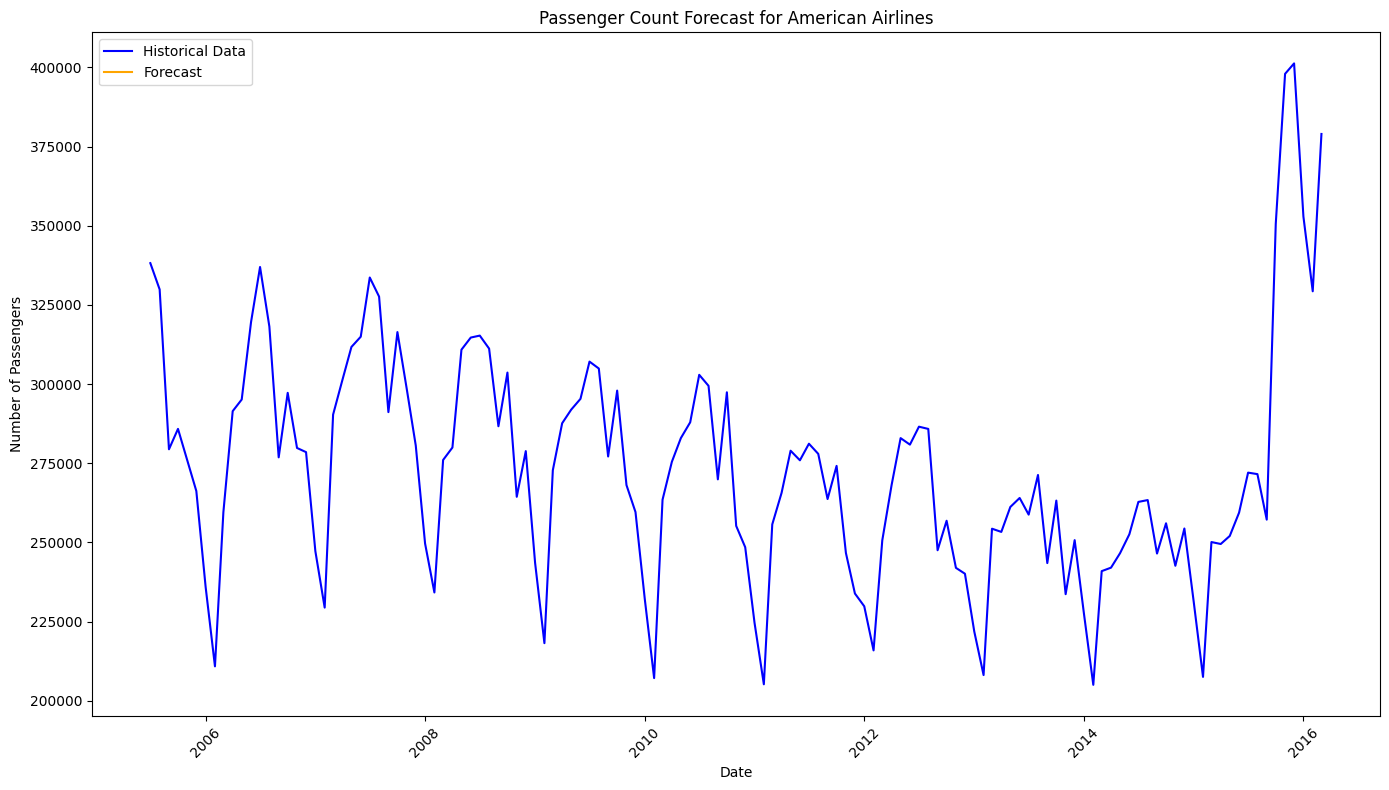

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

df.columns = df.columns.str.strip()

df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')

airline_passengers = df.groupby(['Date', 'Published Airline'])['Passenger Count'].sum().reset_index()

airline_passengers_pivot = airline_passengers.pivot(index='Date', columns='Published Airline', values='Passenger Count')

plt.figure(figsize=(14, 8))
for airline in airline_passengers_pivot.columns:
    plt.plot(airline_passengers_pivot.index, airline_passengers_pivot[airline], label=airline)

plt.title('Passenger Counts by Airline Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

airline_name = 'American Airlines'
airline_data = airline_passengers[airline_passengers['Published Airline'] == airline_name].set_index('Date')

decomposition = seasonal_decompose(airline_data['Passenger Count'], model='additive')
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle(f'Seasonal Decomposition of {airline_name} Passenger Counts', fontsize=16)
plt.show()

result = adfuller(airline_data['Passenger Count'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Differencing may be required.")

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(airline_data['Passenger Count'], ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(airline_data['Passenger Count'], ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

model = ARIMA(airline_data['Passenger Count'], order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=airline_data.index[-1] + pd.DateOffset(months=1), periods=12*2, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

plt.figure(figsize=(14, 8))
plt.plot(airline_data.index, airline_data['Passenger Count'], label='Historical Data', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='orange')
plt.title(f'Passenger Count Forecast for {airline_name}')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
!pip install prophet

Training Exponential Smoothing model...
Exponential Smoothing MAE: 212504.46789918173


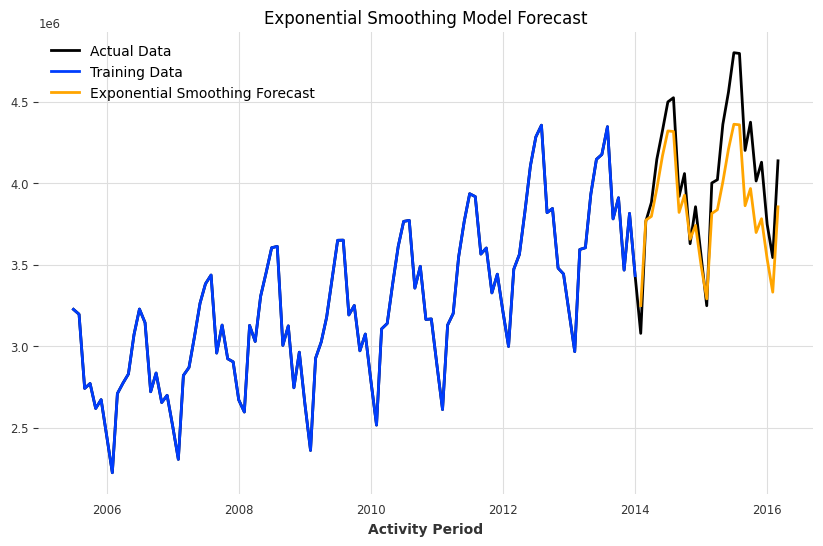

Training ARIMA model...
ARIMA MAE: 347924.03912613436


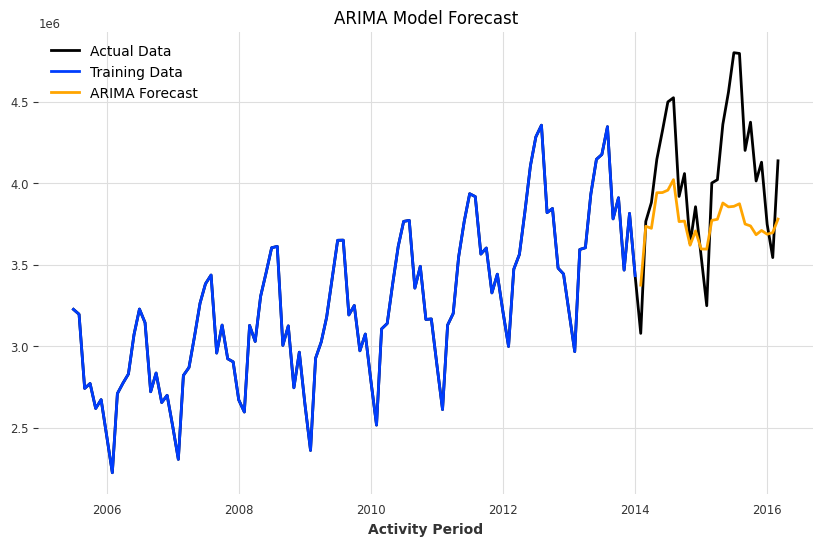

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyuufyc_j/vzity105.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyuufyc_j/psodv6tq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22920', 'data', 'file=/tmp/tmpyuufyc_j/vzity105.json', 'init=/tmp/tmpyuufyc_j/psodv6tq.json', 'output', 'file=/tmp/tmpyuufyc_j/prophet_modelni2j1xm9/prophet_model-20241121071245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training Prophet model...
Prophet MAE: 88241.492961518


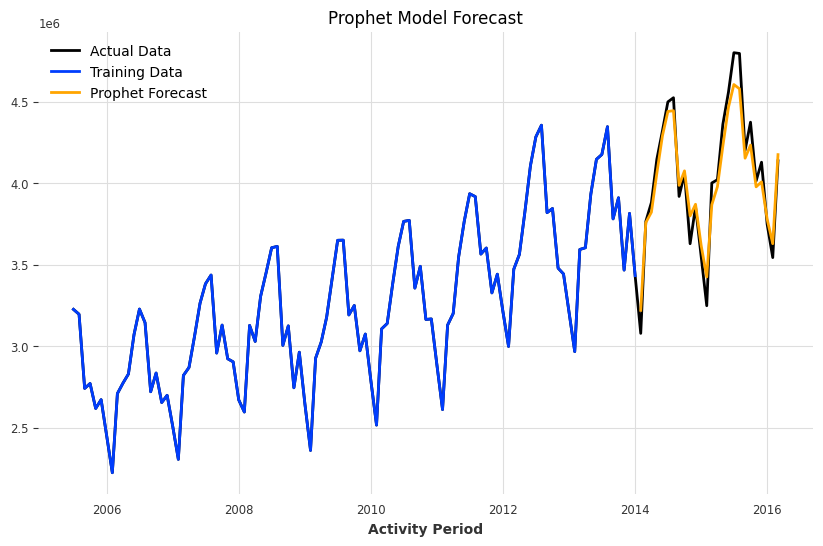

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training N-BEATS model...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

N-BEATS MAE: 128272.9626206863


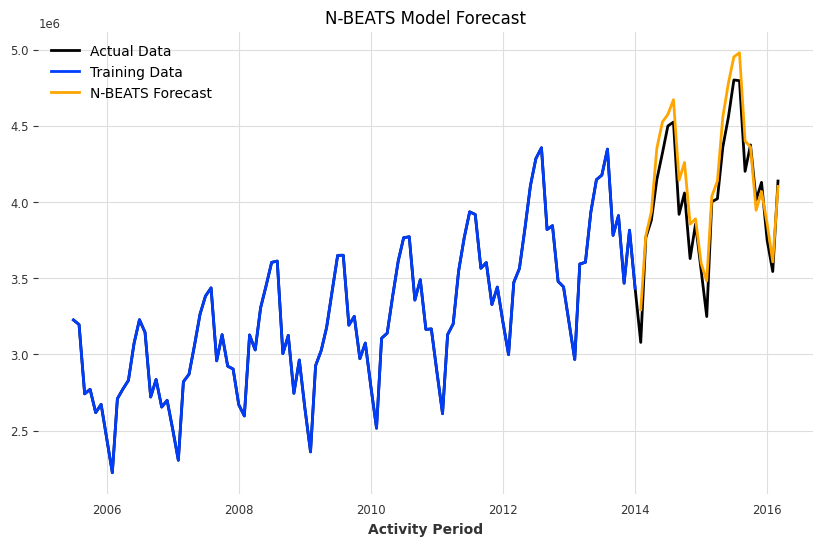


Mean Absolute Error (MAE) for each model:
Exponential Smoothing: 212504.46789918173
ARIMA: 347924.03912613436
Prophet: 88241.492961518
N-BEATS: 128272.9626206863


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet, NBEATSModel
from darts.metrics import mae


data['Activity Period'] = pd.to_datetime(data['Activity Period'], format='%Y%m')
data = data.groupby('Activity Period')['Passenger Count'].sum().reset_index()

series = TimeSeries.from_dataframe(data, 'Activity Period', 'Passenger Count')

train, test = series.split_after(0.8)

models = {
    "Exponential Smoothing": ExponentialSmoothing(),
    "ARIMA": ARIMA(),
    "Prophet": Prophet(),
    "N-BEATS": NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100)
}

results = {}
for name, model in models.items():
    print(f"Training {name} model...")
    model.fit(train)
    prediction = model.predict(len(test))
    error = mae(test, prediction)
    results[name] = {
        "prediction": prediction,
        "error": error
    }
    print(f"{name} MAE: {error}")


    plt.figure(figsize=(10, 6))
    series.plot(label="Actual Data")
    train.plot(label="Training Data")
    prediction.plot(label=f"{name} Forecast", color="orange")
    plt.title(f"{name} Model Forecast")
    plt.legend()
    plt.show()


print("\nMean Absolute Error (MAE) for each model:")
for name, result in results.items():
    print(f"{name}: {result['error']}")

   index  Activity Period Operating Airline Operating Airline IATA Code  \
0      0           200507      ATA Airlines                          TZ   
1      1           200507      ATA Airlines                          TZ   
2      2           200507      ATA Airlines                          TZ   
3      3           200507       Air Canada                           AC   
4      4           200507       Air Canada                           AC   

  Published Airline Published Airline IATA Code    GEO Summary GEO Region  \
0      ATA Airlines                          TZ       Domestic         US   
1      ATA Airlines                          TZ       Domestic         US   
2      ATA Airlines                          TZ       Domestic         US   
3       Air Canada                           AC  International     Canada   
4       Air Canada                           AC  International     Canada   

  Activity Type Code Price Category Code    Terminal Boarding Area  \
0           Depl

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 7 with model DatepartRegression in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 8 with model DatepartRegression in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.3343
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3269  
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3203 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3174 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3135  
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3112 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3121 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3057 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3071 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3055 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2965 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2957 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2968 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2918 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2945 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 31 with model FBProphet in generation 0 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpap_80azi/0ux1zwix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpap_80azi/t0p749xr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54634', 'data', 'file=/tmp/tmpap_80azi/0ux1zwix.json', 'init=/tmp/tmpap_80azi/t0p749xr.json', 'output', 'file=/tmp/tmpap_80azi/prophet_modelcl6q9gw5/prophet_model-20241121101345.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:13:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:13:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 32 with model MultivariateRegression in generation 0 of 5
Model Number: 33 with model MultivariateRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 33 in generation 0: MultivariateRegression
Model Number: 34 with model DatepartRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 34 in generation 0: DatepartRegression
Model Number: 35 with model SeasonalNaive in generation 0 of 5
Model Number: 36 with model DatepartRegression in generation 0 of 5
Model Number: 37 with model UnobservedComponents in generation 0 of 5
Model Number: 38 with model UnobservedComponents in generation 0 of 5
Model Number: 39 with model ETS in generation 0 of 5
Model Number: 40 with model VECM in generation 0 of 5
Template Eval Error: ValueError('Only gave one variable to VECM') in model 40 in generation 0: VECM
Model Number: 41 with model 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 57 with model Cassandra in generation 0 of 5
Model Number: 58 with model Cassandra in generation 0 of 5
Template Eval Error: ValueError('negative dimensions are not allowed') in model 58 in generation 0: Cassandra
Model Number: 59 with model Cassandra in generation 0 of 5
Model Number: 60 with model DMD in generation 0 of 5
Model Number: 61 with model DMD in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 62 with model NVAR in generation 0 of 5
Model Number: 63 with model SectionalMotif in generation 0 of 5
Model Number: 64 with model FBProphet in generation 0 of 5
Model Number: 65 with model ARDL in generation 0 of 5
Model Number: 66 with model FFT in generation 0 of 5
Model Number: 67 with model BasicLinearModel in generation 0 of 5
Template Eval Error: ValueError('matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 37 is different from 39)') in model 67 in generation 0: BasicLinearModel
Model Number: 68 with model BasicLinearModel in generation 0 of 5
Template Eval Error: ValueError('operands could not be broadcast together with remapped shapes [original->remapped]: (12,52)->(12,52,newaxis) (50,1)->(50,1) ') in model 68 in generation 0: BasicLinearModel
Model Number: 69 with model Theta in generation 0 of 5
Model Number: 70 with model MultivariateRegression in generation 0 of 5
Template Eval Error: ValueErro

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1650: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Template Eval Error: Exception("Transformer HolidayTransformer failed on fit from params ffill {'0': {'method': 'rolling_zscore', 'method_params': {'distribution': 'gamma', 'alpha': 0.2, 'rolling_periods': 90, 'center': False}, 'fillna': 'linear', 'transform_dict': {'transformations': {'0': 'DatepartRegression'}, 'transformation_params': {'0': {'datepart_method': 'simple_3', 'regression_model': {'model': 'FastRidge', 'model_params': {}}}}}, 'isolated_only': False, 'on_inverse': False}, '1': {'threshold': 1.0, 'splash_threshold': None, 'use_dayofmonth_holidays': True, 'use_wkdom_holidays': True, 'use_wkdeom_holidays': False, 'use_lunar_holidays': False, 'use_lunar_weekday': False, 'use_islamic_holidays': False, 'use_hebrew_holidays': False, 'use_hindu_holidays': False, 'anomaly_detector_params': {'method': 'med_diff', 'method_params': {'distribution': 'gamma', 'alpha': 0.05}, 'fillna': 'fake_date', 'transform_dict': None, 'isolated_only': False, 'on_inverse': False}, 'remove_excess_anom

/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)


Model Number: 86 with model WindowRegression in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 87 with model DatepartRegression in generation 0 of 5
Template Eval Error: ValueError("Datepart prediction with params {'regression_model': {'model': 'DecisionTree', 'model_params': {'max_depth': None, 'min_samples_split': 2}}, 'datepart_method': 'common_fourier_rw', 'polynomial_degree': None, 'holiday_countries_used': True, 'lags': None, 'forward_lags': None, 'regression_type': None} failed. This is often due to an improperly indexed future_regressor (with drop_most_recent especially)") in model 87 in generation 0: DatepartRegression
Model Number: 88 with model MultivariateRegression in generation 0 of 5
Model Number: 89 with model UnivariateMotif in generation 0 of 5
Model Number: 90 with model MultivariateMotif in generation 0 of 5
Model Number: 91 with model SectionalMotif in generation 0 of 5
Model Number: 92 with model NVAR in generation 0 of 5
Model Number: 93 with model Theta in generation 0 of 5
Model Number: 94 with model ARDL in generation 0 of 5
Model Number: 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 100 with model FFT in generation 0 of 5
Model Number: 101 with model Cassandra in generation 0 of 5
Template Eval Error: ValueError('negative dimensions are not allowed') in model 101 in generation 0: Cassandra
Model Number: 102 with model BasicLinearModel in generation 0 of 5
Template Eval Error: ValueError('operands could not be broadcast together with remapped shapes [original->remapped]: (12,40)->(12,40,newaxis) (38,1)->(38,1) ') in model 102 in generation 0: BasicLinearModel
Model Number: 103 with model TVVAR in generation 0 of 5
Template Eval Error: ValueError('matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 41 is different from 43)') in model 103 in generation 0: TVVAR
Model Number: 104 with model FFT in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 105 with model MultivariateRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 105 in generation 0: MultivariateRegression
Model Number: 106 with model DMD in generation 0 of 5
Model Number: 107 with model UnivariateMotif in generation 0 of 5
Model Number: 108 with model MultivariateRegression in generation 0 of 5
Model Number: 109 with model FFT in generation 0 of 5
Model Number: 110 with model DatepartRegression in generation 0 of 5
Template Eval Error: ValueError("Datepart prediction with params {'regression_model': {'model': 'MLP', 'model_params': {'hidden_layer_sizes': [25, 15, 25], 'max_iter': 250, 'activation': 'tanh', 'solver': 'lbfgs', 'early_stopping': False, 'learning_rate_init': 0.001, 'alpha': 0.1}}, 'datepart_method': 'simple', 'polynomial_degree': None, 'holiday_countries_used': True, 'lags': None, 'forward_lags': None, 'regression_type': None} failed. This is often due to an 

/usr/local/lib/python3.10/dist-packages/autots/models/basics.py:3530: RuntimeWarning: invalid value encountered in sqrt
  self.sigma = np.sqrt(sse / (n - p))


Model Number: 120 with model VECM in generation 0 of 5
Template Eval Error: ValueError('Only gave one variable to VECM') in model 120 in generation 0: VECM
Model Number: 121 with model VECM in generation 0 of 5
Template Eval Error: ValueError('Only gave one variable to VECM') in model 121 in generation 0: VECM
Model Number: 122 with model LastValueNaive in generation 0 of 5
Model Number: 123 with model RRVAR in generation 0 of 5
Model Number: 124 with model MetricMotif in generation 0 of 5
Model Number: 125 with model MultivariateMotif in generation 0 of 5
Model Number: 126 with model LastValueNaive in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)


Model Number: 127 with model ARDL in generation 0 of 5
Model Number: 128 with model SeasonalNaive in generation 0 of 5
Model Number: 129 with model VAR in generation 0 of 5
Template Eval Error: ValueError('Only gave one variable to VAR') in model 129 in generation 0: VAR
Model Number: 130 with model ConstantNaive in generation 0 of 5
Model Number: 131 with model VECM in generation 0 of 5
Template Eval Error: ValueError('Only gave one variable to VECM') in model 131 in generation 0: VECM
Model Number: 132 with model RRVAR in generation 0 of 5
Model Number: 133 with model ETS in generation 0 of 5
Model Number: 134 with model LastValueNaive in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 135 with model DatepartRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 135 in generation 0: DatepartRegression
Model Number: 136 with model GLS in generation 0 of 5
Model Number: 137 with model Cassandra in generation 0 of 5
Template Eval Error: Exception("Transformer DatepartRegression failed on inverse from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '1': {'regression_model': {'model': 'DecisionTree', 'model_params': {'max_depth': 9, 'min_samples_split': 1.0}}, 'datepart_method': 'recurring', 'polynomial_degree': None, 'transform_dict': None, 'holiday_countries_used': True, 'lags': None, 'forward_lags': None}} with ValueError('The feature names should match those that were passed during fit.\\nFeature names unseen at fit time:\\n- Juneteenth National Independence Day\\n- Juneteenth N

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Model Number: 164 with model GLM in generation 0 of 5
Model Number: 165 with model ARCH in generation 0 of 5
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 165 in generation 0: ARCH
Model Number: 166 with model FFT in generation 0 of 5
Model Number: 167 with model GLS in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 168 with model SeasonalNaive in generation 0 of 5
Model Number: 169 with model DatepartRegression in generation 0 of 5
Template Eval Error: ValueError("Datepart prediction with params {'regression_model': {'model': 'Adaboost', 'model_params': {'n_estimators': 100, 'loss': 'linear', 'estimator': None, 'learning_rate': 1, 'max_depth': 3}}, 'datepart_method': 'recurring', 'polynomial_degree': 2, 'holiday_countries_used': True, 'lags': 1, 'forward_lags': None, 'regression_type': None} failed. This is often due to an improperly indexed future_regressor (with drop_most_recent especially)") in model 169 in generation 0: DatepartRegression
Model Number: 170 with model BasicLinearModel in generation 0 of 5
Model Number: 171 with model ARCH in generation 0 of 5
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 171 in generation 0: ARCH
Model Number: 172 with model AverageValueNaive in generation 0 of 5
Model Number: 173 with model ARCH in genera

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_regression.py:509: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 191 with model GLM in generation 0 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 191 in generation 0: GLM
Model Number: 192 with model SeasonalNaive in generation 0 of 5
Model Number: 193 with model MetricMotif in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.10/dist-packages/num

Model Number: 194 with model WindowRegression in generation 0 of 5
Model Number: 195 with model SeasonalityMotif in generation 0 of 5
Model Number: 196 with model UnobservedComponents in generation 0 of 5
Model Number: 197 with model WindowRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 197 in generation 0: WindowRegression
Model Number: 198 with model WindowRegression in generation 0 of 5
Model Number: 199 with model ConstantNaive in generation 0 of 5
Model Number: 200 with model DatepartRegression in generation 0 of 5
Template Eval Error: IndexError('tuple index out of range') in model 200 in generation 0: DatepartRegression
Model Number: 201 with model DatepartRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 201 in generation 0: DatepartRegression
Model Number: 202 with model VAR in generation 0 of 5
Template Eval Error: V

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

Model Number: 204 with model GLS in generation 0 of 5
Model Number: 205 with model SeasonalityMotif in generation 0 of 5
Template Eval Error: ValueError('Model SeasonalityMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 205 in generation 0: SeasonalityMotif
Model Number: 206 with model FFT in generation 0 of 5
Model Number: 207 with model ConstantNaive in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Model Number: 208 with model NVAR in generation 0 of 5
Model Number: 209 with model WindowRegression in generation 0 of 5
Model Number: 210 with model DatepartRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 210 in generation 0: DatepartRegression
Model Number: 211 with model Theta in generation 0 of 5
Model Number: 212 with model FBProphet in generation 0 of 5
Model Number: 213 with model WindowRegression in generation 0 of 5
Model Number: 214 with model ARDL in generation 0 of 5
Model Number: 215 with model WindowRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 215 in generation 0: WindowRegression
Model Number: 216 with model SectionalMotif in generation 0 of 5
Model Number: 217 with model RRVAR in generation 0 of 5
Model Number: 218 with model ARCH in generation 0 of 5
Template Eval Error: ImportError('`arch` package must 

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 224 with model Theta in generation 1 of 5
Model Number: 225 with model SeasonalNaive in generation 1 of 5
Model Number: 226 with model GLS in generation 1 of 5
Model Number: 227 with model Theta in generation 1 of 5
Model Number: 228 with model MetricMotif in generation 1 of 5
Model Number: 229 with model MetricMotif in generation 1 of 5
Model Number: 230 with model RRVAR in generation 1 of 5
Model Number: 231 with model FBProphet in generation 1 of 5
Model Number: 232 with model Cassandra in generation 1 of 5
Model Number: 233 with model UnobservedComponents in generation 1 of 5
Model Number: 234 with model WindowRegression in generation 1 of 5
Model Number: 235 with model Theta in generation 1 of 5
Model Number: 236 with model WindowRegression in generation 1 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 237 with model AverageValueNaive in generation 1 of 5
Model Number: 238 with model DatepartRegression in generation 1 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 239 with model FFT in generation 1 of 5
Model Number: 240 with model WindowRegression in generation 1 of 5
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 118348570624.0000  
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 118348283904.0000 
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118347939840.0000 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118347456512.0000 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118346784768.0000 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118345875456.0000 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118344704000.0000 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118343221248.0000 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118341410816.0000 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118339248128.0000 


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Model Number: 241 with model DatepartRegression in generation 1 of 5
Model Number: 242 with model MultivariateMotif in generation 1 of 5
Model Number: 243 with model SectionalMotif in generation 1 of 5
Model Number: 244 with model Theta in generation 1 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 245 with model RRVAR in generation 1 of 5
Model Number: 246 with model FFT in generation 1 of 5
Template Eval Error: Exception("Transformer HolidayTransformer failed on fit from params ffill {'0': {'lag_1': 2, 'method': 'LastValue'}, '1': {'lag_1': 12, 'method': 5}, '2': {}, '3': {'threshold': 0.8, 'splash_threshold': None, 'use_dayofmonth_holidays': True, 'use_wkdom_holidays': True, 'use_wkdeom_holidays': False, 'use_lunar_holidays': True, 'use_lunar_weekday': False, 'use_islamic_holidays': False, 'use_hebrew_holidays': False, 'use_hindu_holidays': False, 'anomaly_detector_params': {'method': 'rolling_zscore', 'method_params': {'distribution': 'cauchy', 'alpha': 0.05, 'rolling_periods': 90, 'center': False}, 'fillna': 'ffill', 'transform_dict': {'fillna': 'mean', 'transformations': {'0': 'PCA'}, 'transformation_params': {'0': {'whiten': True, 'n_components': 10}}}, 'isolated_only': False, 'on_inverse': False}, 'remove_excess_anomalies': True, 'impact': 'regression', 'reg

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 251 with model GLS in generation 1 of 5
Model Number: 252 with model ARDL in generation 1 of 5
Template Eval Error: Exception("Transformer DatepartRegression failed on inverse from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False, 'threshold': None, 'threshold_method': 'mean'}, '1': {'method': 'rolling_zscore', 'method_params': {'distribution': 'gamma', 'alpha': 0.1, 'rolling_periods': 90, 'center': False}, 'fillna': 'ffill', 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}, 'isolated_only': False, 'on_inverse': False}, '2': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '3': {'regression_model': {'model': 'DecisionTree', 'model_params': {'max_depth': None, 'min_samples_split': 1.0}}, 'datepart_method': [7, 365.25], 'polynomial_degree': None, 'transform_d

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 256 with model WindowRegression in generation 1 of 5
Template Eval Error: ValueError('X has 44 features, but StandardScaler is expecting 42 features as input.') in model 256 in generation 1: WindowRegression
Model Number: 257 with model BasicLinearModel in generation 1 of 5
Model Number: 258 with model GLM in generation 1 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 259 with model Theta in generation 1 of 5
Model Number: 260 with model ETS in generation 1 of 5
Model Number: 261 with model WindowRegression in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 261 in generation 1: WindowRegression
Model Number: 262 with model FFT in generation 1 of 5
Model Number: 263 with model MultivariateMotif in generation 1 of 5
Model Number: 264 with model RRVAR in generation 1 of 5
Model Number: 265 with model SeasonalityMotif in generation 1 of 5
Model Number: 266 with model DMD in generation 1 of 5
Model Number: 267 with model MultivariateMotif in generation 1 of 5
Model Number: 268 with model AverageValueNaive in generation 1 of 5
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill {'0': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 1}} with error ValueError('BTCD only works on multivarate series')") in model 268 in gen

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 294 with model MetricMotif in generation 1 of 5
Model Number: 295 with model Cassandra in generation 1 of 5
Model Number: 296 with model UnivariateMotif in generation 1 of 5
Model Number: 297 with model RRVAR in generation 1 of 5
Model Number: 298 with model FBProphet in generation 1 of 5
Model Number: 299 with model UnivariateMotif in generation 1 of 5
Template Eval Error: IndexError('index 91 is out of bounds for axis 0 with size 1') in model 299 in generation 1: UnivariateMotif
Model Number: 300 with model Theta in generation 1 of 5
Model Number: 301 with model LastValueNaive in generation 1 of 5
Model Number: 302 with model LastValueNaive in generation 1 of 5
Model Number: 303 with model ARIMA in generation 1 of 5
Model Number: 304 with model DatepartRegression in generation 1 of 5
Model Number: 305 with model SeasonalNaive in generation 1 of 5
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'addit

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Model Number: 309 with model MetricMotif in generation 1 of 5
Model Number: 310 with model Theta in generation 1 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 311 with model LastValueNaive in generation 1 of 5
Model Number: 312 with model ARDL in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 312 in generation 1: ARDL
Model Number: 313 with model FBProphet in generation 1 of 5
No anomalies detected.


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 314 with model FBProphet in generation 1 of 5
Model Number: 315 with model RRVAR in generation 1 of 5
Template Eval Error: Exception("Transformer RegressionFilter failed on fit from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'output_distribution': 'uniform', 'n_quantiles': 39}, '2': {'sigma': 2.5, 'rolling_window': 90, 'run_order': 'season_first', 'regression_params': {'regression_model': {'model': 'ElasticNet', 'model_params': {'l1_ratio': 0.9, 'fit_intercept': True, 'selection': 'random', 'max_iter': 1000}}, 'datepart_method': 'common_fourier', 'polynomial_degree': None, 'transform_dict': {'fillna': 'rolling_mean', 'transformations': {'0': 'AlignLastValue', '1': 'RollingMeanTransformer'}, 'transformation_params': {'0': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'max'}, '

/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)


Model Number: 317 with model SectionalMotif in generation 1 of 5
Model Number: 318 with model ETS in generation 1 of 5
Model Number: 319 with model GLM in generation 1 of 5
Model Number: 320 with model FFT in generation 1 of 5
Model Number: 321 with model SectionalMotif in generation 1 of 5
Model Number: 322 with model MetricMotif in generation 1 of 5
Model Number: 323 with model UnobservedComponents in generation 1 of 5
Model Number: 324 with model LastValueNaive in generation 1 of 5
Model Number: 325 with model MultivariateRegression in generation 1 of 5
Model Number: 326 with model WindowRegression in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 326 in generation 1: WindowRegression
Model Number: 327 with model LastValueNaive in generation 1 of 5
Model Number: 328 with model UnivariateMotif in generation 1 of 5
Model Number: 329 with model ETS in generation 1 of 5
Model Number: 330 with model GLS in generation 1 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params mean {'0': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gbtree', 'colsample_bylevel': 0.54, 'learning_rate': 0.0125, 'max_depth': 11, 'min_child_weight': 0.0127203, 'n_estimators': 319}, 'datepart_method': ['dayofweek', 365.25]}, 'fillna': 'ffill'}, '1': {'lag': 2, 'fill': 'bfill'}, '2': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 0.9, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '3': {'method': 'rolling_zscore', 'method_params': {'distribution': 'uniform', 'alpha': 0.03, 'rolling_periods': 90, 'center': True}, 'fillna': 'rolling_mean_24', 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}, 'isolated_only': False, 'on_inverse': False}} with error ValueError('Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]')") in model 343 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.918e+12, tolerance: 1.454e+09
  model = cd_fast.enet_coordinate_descent(


Template Eval Error: ValueError('negative dimensions are not allowed') in model 352 in generation 1: Cassandra
Model Number: 353 with model NVAR in generation 1 of 5
Model Number: 354 with model UnivariateMotif in generation 1 of 5
Model Number: 355 with model SeasonalityMotif in generation 1 of 5
Model Number: 356 with model Theta in generation 1 of 5
Model Number: 357 with model GLM in generation 1 of 5
Model Number: 358 with model WindowRegression in generation 1 of 5
Model Number: 359 with model DatepartRegression in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 359 in generation 1: DatepartRegression
Model Number: 360 with model MultivariateRegression in generation 1 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 361 with model AverageValueNaive in generation 1 of 5
Model Number: 362 with model Theta in generation 1 of 5
Model Number: 363 with model MultivariateRegression in generation 1 of 5
Model Number: 364 with model FFT in generation 1 of 5
Model Number: 365 with model AverageValueNaive in generation 1 of 5
Model Number: 366 with model NVAR in generation 1 of 5
Model Number: 367 with model ARDL in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 367 in generation 1: ARDL
Model Number: 368 with model AverageValueNaive in generation 1 of 5
Model Number: 369 with model UnobservedComponents in generation 1 of 5
Model Number: 370 with model SectionalMotif in generation 1 of 5
Model Number: 371 with model SeasonalNaive in generation 1 of 5
Model Number: 372 with model MultivariateRegression in generation 1 of 5
Model Number: 373 with model MultivariateRegression in generation 1 of 5
New Generation: 2 of 5
Model N

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 385 with model Theta in generation 2 of 5
Model Number: 386 with model NVAR in generation 2 of 5
Model Number: 387 with model Theta in generation 2 of 5
Model Number: 388 with model MultivariateRegression in generation 2 of 5
Template Eval Error: LightGBMError('Unknown objective type name: regression,mape') in model 388 in generation 2: MultivariateRegression
Model Number: 389 with model SeasonalityMotif in generation 2 of 5
Model Number: 390 with model LastValueNaive in generation 2 of 5
Model Number: 391 with model WindowRegression in generation 2 of 5
Model Number: 392 with model SectionalMotif in generation 2 of 5
Model Number: 393 with model AverageValueNaive in generation 2 of 5
Model Number: 394 with model SeasonalNaive in generation 2 of 5
Model Number: 395 with model SeasonalityMotif in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 396 with model ARDL in generation 2 of 5
Model Number: 397 with model SeasonalityMotif in generation 2 of 5
Model Number: 398 with model GLS in generation 2 of 5
Model Number: 399 with model MultivariateMotif in generation 2 of 5
Model Number: 400 with model DatepartRegression in generation 2 of 5
Model Number: 401 with model LastValueNaive in generation 2 of 5
Model Number: 402 with model ARDL in generation 2 of 5
Model Number: 403 with model WindowRegression in generation 2 of 5
Model Number: 404 with model UnivariateMotif in generation 2 of 5
Model Number: 405 with model MetricMotif in generation 2 of 5
Model Number: 406 with model LastValueNaive in generation 2 of 5
Model Number: 407 with model SeasonalNaive in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 408 with model FBProphet in generation 2 of 5
Template Eval Error: Exception('Transformer PCA failed on fit from params rolling_mean {\'0\': {}, \'1\': {\'whiten\': False, \'n_components\': 24}, \'2\': {}, \'3\': {\'constant\': 1, \'reintroduction_model\': {\'model\': \'KNN\', \'model_params\': {\'n_neighbors\': 5, \'weights\': \'uniform\', \'p\': 2, \'leaf_size\': 30}, \'datepart_method\': \'recurring\'}, \'fillna\': \'linear\'}, \'4\': {\'threshold\': 0.8, \'splash_threshold\': None, \'use_dayofmonth_holidays\': True, \'use_wkdom_holidays\': True, \'use_wkdeom_holidays\': False, \'use_lunar_holidays\': False, \'use_lunar_weekday\': False, \'use_islamic_holidays\': False, \'use_hebrew_holidays\': False, \'use_hindu_holidays\': False, \'anomaly_detector_params\': {\'method\': \'zscore\', \'method_params\': {\'distribution\': \'chi2\', \'alpha\': 0.05}, \'fillna\': \'ffill\', \'transform_dict\': {\'fillna\': \'nearest\', \'transformations\': {\'0\': \'SeasonalDifference\',

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 416 with model ETS in generation 2 of 5
Model Number: 417 with model MetricMotif in generation 2 of 5
Model Number: 418 with model UnivariateMotif in generation 2 of 5
Model Number: 419 with model Cassandra in generation 2 of 5
Model Number: 420 with model ARDL in generation 2 of 5
Model Number: 421 with model FFT in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 422 with model WindowRegression in generation 2 of 5
Model Number: 423 with model UnobservedComponents in generation 2 of 5
Model Number: 424 with model WindowRegression in generation 2 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 424 in generation 2: WindowRegression
Model Number: 425 with model MultivariateMotif in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 426 with model ARIMA in generation 2 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 426 in generation 2: ARIMA
Model Number: 427 with model FFT in generation 2 of 5
Model Number: 428 with model Theta in generation 2 of 5
Template Eval Error: Exception("Transformer DatepartRegression failed on inverse from params zero {'0': {'lag': 1, 'fill': 'bfill'}, '1': {'regression_model': {'model': 'RandomForest', 'model_params': {'n_estimators': 1000, 'min_samples_leaf': 1, 'bootstrap': False}}, 'datepart_method': 'simple_binarized', 'polynomial_degree': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'ClipOutliers'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 4}}}, 'holiday_countries_used': True, 'lags': None, 'forward_lags': None}, '2': {'discretization': 'lower', 'n_bins': 20}} with ValueError('The feature names should match those that were passed during fit.\\nFeature names unsee

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 434 with model UnobservedComponents in generation 2 of 5
Model Number: 435 with model Theta in generation 2 of 5
Model Number: 436 with model SeasonalNaive in generation 2 of 5
Model Number: 437 with model ETS in generation 2 of 5
Model Number: 438 with model ConstantNaive in generation 2 of 5
Model Number: 439 with model AverageValueNaive in generation 2 of 5
Model Number: 440 with model Theta in generation 2 of 5
Model Number: 441 with model FFT in generation 2 of 5
Model Number: 442 with model MultivariateRegression in generation 2 of 5
Model Number: 443 with model MultivariateMotif in generation 2 of 5
Model Number: 444 with model SectionalMotif in generation 2 of 5
Model Number: 445 with model AverageValueNaive in generation 2 of 5
Model Number: 446 with model RRVAR in generation 2 of 5
Model Number: 447 with model Cassandra in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)


Model Number: 448 with model Cassandra in generation 2 of 5
Template Eval Error: UnboundLocalError("local variable 'slope' referenced before assignment") in model 448 in generation 2: Cassandra
Model Number: 449 with model RRVAR in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 450 with model ETS in generation 2 of 5
Model Number: 451 with model ARDL in generation 2 of 5
Model Number: 452 with model LastValueNaive in generation 2 of 5
Model Number: 453 with model ARDL in generation 2 of 5
Model Number: 454 with model ETS in generation 2 of 5
Model Number: 455 with model FFT in generation 2 of 5
Model Number: 456 with model Cassandra in generation 2 of 5
Template Eval Error: TypeError('Cannot infer number of levels from empty list') in model 456 in generation 2: Cassandra
Model Number: 457 with model ARIMA in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 458 with model MetricMotif in generation 2 of 5
Model Number: 459 with model ARDL in generation 2 of 5
Model Number: 460 with model GLS in generation 2 of 5
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill_mean_biased {'0': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'max'}, '1': {'output_distribution': 'uniform', 'n_quantiles': 39}, '2': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 2}, '3': {'det_order': -1, 'k_ar_diff': 0}, '4': {'low': 4, 'high': 40, 'K': 1, 'lanczos_factor': False, 'return_diff': True, 'on_transform': True, 'on_inverse': False}} with error ValueError('BTCD only works on multivarate series')") in model 460 in generation 2: GLS
Model Number: 461 with model WindowRegression in generation 2 of 5
Model Number: 462 with model GLM in generation 2 of 5
Model Number: 463 with model GLS in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 464 with model MultivariateRegression in generation 2 of 5
Model Number: 465 with model MultivariateRegression in generation 2 of 5
Model Number: 466 with model Theta in generation 2 of 5
Model Number: 467 with model Cassandra in generation 2 of 5
Template Eval Error: UnboundLocalError("local variable 'slope' referenced before assignment") in model 467 in generation 2: Cassandra
Model Number: 468 with model WindowRegression in generation 2 of 5
Model Number: 469 with model FFT in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 470 with model Theta in generation 2 of 5
Model Number: 471 with model NVAR in generation 2 of 5
Model Number: 472 with model DatepartRegression in generation 2 of 5
Template Eval Error: InvalidParameterError("The 'alpha' parameter of MLPRegressor must be a float in the range [0.0, inf). Got None instead.") in model 472 in generation 2: DatepartRegression
Model Number: 473 with model Theta in generation 2 of 5
Model Number: 474 with model UnivariateMotif in generation 2 of 5
Model Number: 475 with model LastValueNaive in generation 2 of 5
Model Number: 476 with model SeasonalityMotif in generation 2 of 5
Model Number: 477 with model SectionalMotif in generation 2 of 5
Model Number: 478 with model Theta in generation 2 of 5
Model Number: 479 with model MultivariateRegression in generation 2 of 5
Model Number: 480 with model MultivariateRegression in generation 2 of 5
Model Number: 481 with model SeasonalNaive in generation 2 of 5
Model Number: 482 with model MultivariateMo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 486 with model MetricMotif in generation 2 of 5
Model Number: 487 with model GLM in generation 2 of 5
Model Number: 488 with model WindowRegression in generation 2 of 5
Model Number: 489 with model Cassandra in generation 2 of 5
Template Eval Error: Exception("Transformer SeasonalDifference failed on fit from params rolling_mean {'0': {'lag_1': 364, 'method': 2}, '1': {'window': 100}, '2': {}} with error ValueError('cannot reshape array of size 117 into shape (0,364,newaxis)')") in model 489 in generation 2: Cassandra
Model Number: 490 with model MetricMotif in generation 2 of 5
Model Number: 491 with model MultivariateRegression in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 492 with model MultivariateRegression in generation 2 of 5
Model Number: 493 with model MultivariateRegression in generation 2 of 5
Model Number: 494 with model SectionalMotif in generation 2 of 5
Model Number: 495 with model MetricMotif in generation 2 of 5
Model Number: 496 with model ETS in generation 2 of 5
Model Number: 497 with model ConstantNaive in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 498 with model FBProphet in generation 2 of 5
No anomalies detected.
Model Number: 499 with model ETS in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 500 with model UnivariateMotif in generation 2 of 5
Model Number: 501 with model GLS in generation 2 of 5
Model Number: 502 with model MetricMotif in generation 2 of 5
Model Number: 503 with model Cassandra in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 504 with model MultivariateRegression in generation 2 of 5
Model Number: 505 with model DatepartRegression in generation 2 of 5
Model Number: 506 with model ARDL in generation 2 of 5
Model Number: 507 with model MetricMotif in generation 2 of 5
Model Number: 508 with model DMD in generation 2 of 5
Model Number: 509 with model RRVAR in generation 2 of 5
Model Number: 510 with model UnivariateMotif in generation 2 of 5
Model Number: 511 with model SeasonalNaive in generation 2 of 5
Model Number: 512 with model MultivariateMotif in generation 2 of 5
Model Number: 513 with model GLS in generation 2 of 5
Model Number: 514 with model GLM in generation 2 of 5
Model Number: 515 with model SeasonalNaive in generation 2 of 5
Model Number: 516 with model MultivariateRegression in generation 2 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 517 with model ETS in generation 2 of 5
Model Number: 518 with model AverageValueNaive in generation 2 of 5
Model Number: 519 with model ARDL in generation 2 of 5
Model Number: 520 with model DatepartRegression in generation 2 of 5
Model Number: 521 with model RRVAR in generation 2 of 5
Model Number: 522 with model MultivariateRegression in generation 2 of 5
Model Number: 523 with model UnobservedComponents in generation 2 of 5
New Generation: 3 of 5
Model Number: 524 with model WindowRegression in generation 3 of 5
Model Number: 525 with model GLM in generation 3 of 5
Model Number: 526 with model ETS in generation 3 of 5
Model Number: 527 with model UnivariateMotif in generation 3 of 5
Model Number: 528 with model SectionalMotif in generation 3 of 5
Model Number: 529 with model MultivariateMotif in generation 3 of 5
Model Number: 530 with model WindowRegression in generation 3 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") i

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 537 with model UnivariateMotif in generation 3 of 5
Model Number: 538 with model ETS in generation 3 of 5
Model Number: 539 with model GLS in generation 3 of 5
Model Number: 540 with model MultivariateRegression in generation 3 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.838e+12, tolerance: 3.041e+09
  model = cd_fast.enet_coordinate_descent(


Model Number: 541 with model DMD in generation 3 of 5
Model Number: 542 with model DatepartRegression in generation 3 of 5
Template Eval Error: InvalidParameterError("The 'alpha' parameter of MLPRegressor must be a float in the range [0.0, inf). Got None instead.") in model 542 in generation 3: DatepartRegression
Model Number: 543 with model Theta in generation 3 of 5
Model Number: 544 with model FBProphet in generation 3 of 5
No anomalies detected.
Model Number: 545 with model FFT in generation 3 of 5
Model Number: 546 with model FFT in generation 3 of 5
Model Number: 547 with model WindowRegression in generation 3 of 5
interpolating
Template Eval Error: ValueError('Model WindowRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 547 in generation 3: WindowRegression
Model Number: 548 with model MultivariateMotif in generation 3 of 5
Model Number: 549 with model Cassandra in generation 3 of 5
Model Number: 550 with model AverageValueNaive in generation 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_regression.py:509: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 551 with model UnobservedComponents in generation 3 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 551 in generation 3: UnobservedComponents
Model Number: 552 with model DatepartRegression in generation 3 of 5
Model Number: 553 with model SeasonalityMotif in generation 3 of 5
Model Number: 554 with model SeasonalityMotif in generation 3 of 5
Model Number: 555 with model WindowRegression in generation 3 of 5
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 555 in generation 3: WindowRegression
Model Number: 556 with model ARDL in generation 3 of 5
Model Number: 557 with model ARDL in generation 3 of 5
Model Number: 558 with model MultivariateMotif in generation 3 of 5
Model Number: 559 with model MultivariateRegression in generation 3 of 5
Model Number: 560 with model Cassandra in generation 3 of 5
Template Eval Error: UnboundLocalError("local v

/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1294: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp.replace(replace_dict).astype(float).fillna(0),
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1262: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an 

Model Number: 564 with model ARDL in generation 3 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 564 in generation 3: ARDL
Model Number: 565 with model MultivariateMotif in generation 3 of 5
Model Number: 566 with model SeasonalNaive in generation 3 of 5
Model Number: 567 with model NVAR in generation 3 of 5
Model Number: 568 with model UnivariateMotif in generation 3 of 5
Model Number: 569 with model ARDL in generation 3 of 5
Model Number: 570 with model RRVAR in generation 3 of 5
Model Number: 571 with model Theta in generation 3 of 5
Model Number: 572 with model SeasonalityMotif in generation 3 of 5
Model Number: 573 with model WindowRegression in generation 3 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 574 with model ARDL in generation 3 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 574 in generation 3: ARDL
Model Number: 575 with model GLM in generation 3 of 5
Model Number: 576 with model GLS in generation 3 of 5
Model Number: 577 with model MultivariateRegression in generation 3 of 5
Model Number: 578 with model DatepartRegression in generation 3 of 5
Template Eval Error: IndexError('tuple index out of range') in model 578 in generation 3: DatepartRegression
Model Number: 579 with model UnivariateMotif in generation 3 of 5
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params ffill {'0': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gblinear', 'max_depth': 6, 'eta': 0.3, 'min_child_weight': 2, 'subsample': 1, 'colsample_bylevel': 1, 'reg_alpha': 0.001, 'reg_lambda': 1, 'n_estimators': 1000, 'multi_strategy': 'multi_output_tree', 'tree

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 586 with model SectionalMotif in generation 3 of 5
Model Number: 587 with model GLS in generation 3 of 5
Model Number: 588 with model DMD in generation 3 of 5
Model Number: 589 with model SeasonalityMotif in generation 3 of 5
Model Number: 590 with model GLM in generation 3 of 5
Model Number: 591 with model DatepartRegression in generation 3 of 5
Model Number: 592 with model ETS in generation 3 of 5
Model Number: 593 with model MetricMotif in generation 3 of 5
Model Number: 594 with model MetricMotif in generation 3 of 5
Model Number: 595 with model WindowRegression in generation 3 of 5
Model Number: 596 with model GLM in generation 3 of 5
Model Number: 597 with model SectionalMotif in generation 3 of 5
Model Number: 598 with model Cassandra in generation 3 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 599 with model GLM in generation 3 of 5
Model Number: 600 with model NVAR in generation 3 of 5
Model Number: 601 with model MetricMotif in generation 3 of 5
Model Number: 602 with model ARDL in generation 3 of 5
Model Number: 603 with model ARDL in generation 3 of 5
Model Number: 604 with model SeasonalNaive in generation 3 of 5
Model Number: 605 with model SeasonalNaive in generation 3 of 5
Model Number: 606 with model ARDL in generation 3 of 5
Model Number: 607 with model ARDL in generation 3 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 607 in generation 3: ARDL
Model Number: 608 with model UnivariateMotif in generation 3 of 5
Model Number: 609 with model SectionalMotif in generation 3 of 5
Model Number: 610 with model MultivariateRegression in generation 3 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 611 with model ETS in generation 3 of 5
Template Eval Error: Exception("Transformer BTCD failed on fit from params mean {'0': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 2}, '1': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 0.7, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'max'}} with error ValueError('BTCD only works on multivarate series')") in model 611 in generation 3: ETS
Model Number: 612 with model WindowRegression in generation 3 of 5
Template Eval Error: Exception('Transformer PCA failed on fit from params pchip {\'0\': {\'rows\': 1, \'lag\': 1, \'method\': \'additive\', \'strength\': 0.7, \'first_value_only\': False, \'threshold\': 10, \'threshold_method\': \'mean\'}, \'1\': {\'rows\': 7, \'lag\': 1, \'method\': \'additive\', \'strength\': 1.0, \'first_value_only\': True, \'threshold\': 3, \'threshold_method\': \'max\'}, \'2\': {\'whiten\': False, \'n_components\': 24}} with error ValueError("n_compo

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 622 with model MultivariateRegression in generation 3 of 5
Model Number: 623 with model ARIMA in generation 3 of 5
Model Number: 624 with model ETS in generation 3 of 5
Model Number: 625 with model GLS in generation 3 of 5
Model Number: 626 with model GLM in generation 3 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 626 in generation 3: GLM
Model Number: 627 with model FFT in generation 3 of 5
Model Number: 628 with model DMD in generation 3 of 5


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 629 with model GLS in generation 3 of 5
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params nearest {'0': {}, '1': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gbtree', 'max_depth': 6, 'eta': 0.003, 'min_child_weight': 1, 'subsample': 1, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100}, 'datepart_method': [7, 365.25]}, 'fillna': 'pchip'}, '2': {}, '3': {'lag_1': 96, 'method': 'LastValue'}} with error ValueError('Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]')") in model 629 in generation 3: GLS
Model Number: 630 with model MultivariateRegression in generation 3 of 5
Model Number: 631 with model Cassandra in generation 3 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 632 with model ETS in generation 3 of 5
Model Number: 633 with model Theta in generation 3 of 5
Model Number: 634 with model WindowRegression in generation 3 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 634 in generation 3: WindowRegression
Model Number: 635 with model SeasonalNaive in generation 3 of 5
Model Number: 636 with model MetricMotif in generation 3 of 5
Model Number: 637 with model Theta in generation 3 of 5
Model Number: 638 with model GLM in generation 3 of 5
Model Number: 639 with model MultivariateRegression in generation 3 of 5
Model Number: 640 with model NVAR in generation 3 of 5
Model Number: 641 with model ConstantNaive in generation 3 of 5
Model Number: 642 with model GLM in generation 3 of 5
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 642 in generation 3: GLM
Model Number: 643 wi

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 645 with model BasicLinearModel in generation 3 of 5
Model Number: 646 with model Cassandra in generation 3 of 5
Model Number: 647 with model SeasonalNaive in generation 3 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 648 with model Theta in generation 3 of 5
Model Number: 649 with model MultivariateMotif in generation 3 of 5
Model Number: 650 with model DatepartRegression in generation 3 of 5
Model Number: 651 with model AverageValueNaive in generation 3 of 5
Model Number: 652 with model ARIMA in generation 3 of 5
Model Number: 653 with model RRVAR in generation 3 of 5
Model Number: 654 with model SeasonalNaive in generation 3 of 5
Model Number: 655 with model MultivariateRegression in generation 3 of 5
Model Number: 656 with model UnobservedComponents in generation 3 of 5
Model Number: 657 with model ARDL in generation 3 of 5
Model Number: 658 with model SeasonalNaive in generation 3 of 5
Model Number: 659 with model FFT in generation 3 of 5
Model Number: 660 with model GLM in generation 3 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 660 in generation 3: GLM
Model Number: 661 with model SectionalMotif in genera

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 664 with model WindowRegression in generation 3 of 5
Template Eval Error: Exception('Transformer PCA failed on fit from params rolling_mean {\'0\': {\'rows\': 7, \'lag\': 1, \'method\': \'additive\', \'strength\': 1.0, \'first_value_only\': True, \'threshold\': 3, \'threshold_method\': \'max\'}, \'1\': {\'whiten\': False, \'n_components\': 24}} with error ValueError("n_components=24 must be between 0 and min(n_samples, n_features)=1 with svd_solver=\'covariance_eigh\'")') in model 664 in generation 3: WindowRegression
Model Number: 665 with model WindowRegression in generation 3 of 5
Model Number: 666 with model UnivariateMotif in generation 3 of 5
Model Number: 667 with model Cassandra in generation 3 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 668 with model MultivariateMotif in generation 3 of 5
Model Number: 669 with model GLS in generation 3 of 5
Model Number: 670 with model NVAR in generation 3 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 671 with model GLS in generation 3 of 5
Model Number: 672 with model FBProphet in generation 3 of 5
No anomalies detected.
Model Number: 673 with model FFT in generation 3 of 5
New Generation: 4 of 5
Model Number: 674 with model AverageValueNaive in generation 4 of 5
Model Number: 675 with model MultivariateMotif in generation 4 of 5
Template Eval Error: IndexError('index 95 is out of bounds for axis 0 with size 1') in model 675 in generation 4: MultivariateMotif
Model Number: 676 with model MultivariateRegression in generation 4 of 5
Model Number: 677 with model ARDL in generation 4 of 5
Model Number: 678 with model FFT in generation 4 of 5
Model Number: 679 with model MetricMotif in generation 4 of 5
Model Number: 680 with model Cassandra in generation 4 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 680 in generation 4: Cassandra
Model Number: 681 with model AverageValueNaive in generation 4 of 5
Model Number: 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 684 with model GLS in generation 4 of 5
Model Number: 685 with model Theta in generation 4 of 5
Model Number: 686 with model AverageValueNaive in generation 4 of 5
Template Eval Error: Exception('Transformer PCA failed on fit from params ffill {\'0\': {\'model\': \'Linear\', \'phi\': 1, \'window\': 90}, \'1\': {\'whiten\': True, \'n_components\': 100}, \'2\': {\'rows\': 1, \'lag\': 1, \'method\': \'additive\', \'strength\': 1.0, \'first_value_only\': False, \'threshold\': 10, \'threshold_method\': \'mean\'}} with error ValueError("n_components=100 must be between 0 and min(n_samples, n_features)=1 with svd_solver=\'covariance_eigh\'")') in model 686 in generation 4: AverageValueNaive
Model Number: 687 with model SeasonalNaive in generation 4 of 5
Model Number: 688 with model ARDL in generation 4 of 5
Model Number: 689 with model DMD in generation 4 of 5

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



Model Number: 690 with model ARDL in generation 4 of 5
Model Number: 691 with model LastValueNaive in generation 4 of 5
Template Eval Error: Exception("Transformer FIRFilter failed on fit from params ffill {'0': {'model': 'Linear', 'phi': 0.999, 'window': None, 'transform_dict': None}, '1': {'numtaps': 64, 'cutoff_hz': 5, 'window': 'hann', 'sampling_frequency': 2, 'on_transform': True, 'on_inverse': False}, '2': {'window': 10}} with error ValueError('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.')") in model 691 in generation 4: LastValueNaive
Model Number: 692 with model ARIMA in generation 4 of 5
Model Number: 693 with model SeasonalNaive in generation 4 of 5
Model Number: 694 with model MultivariateRegression in generation 4 of 5
Model Number: 695 with model ARDL in generation 4 of 5
Model Number: 696 with model GLS in generation 4 of 5
Model Number: 697 with model ConstantNaive in generation 4 of 5
Model Number: 698 with model MultivariateRegress

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 700 with model Theta in generation 4 of 5
Model Number: 701 with model GLS in generation 4 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 702 with model Theta in generation 4 of 5
Model Number: 703 with model MetricMotif in generation 4 of 5
Model Number: 704 with model AverageValueNaive in generation 4 of 5
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params median {'0': {'rolling_window': 30, 'n_tails': 90, 'n_future': 0.2, 'method': 'median', 'macro_micro': True}, '1': {'constant': 1, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gbtree', 'colsample_bylevel': 0.54, 'learning_rate': 0.0125, 'max_depth': 11, 'min_child_weight': 0.0127203, 'n_estimators': 319}, 'datepart_method': 'recurring'}, 'fillna': 'pchip'}, '2': {'decimals': 0, 'on_transform': True, 'on_inverse': True}, '3': {}, '4': {'model': 'ElasticNet', 'changepoint_spacing': 6, 'changepoint_distance_end': 360, 'datepart_method': None}} with error ValueError('Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]')") in model 704 in generation 4: AverageValueNaive
M

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_linear_loss.py:295: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_linear_loss.py:295: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


Model Number: 710 with model DatepartRegression in generation 4 of 5
Model Number: 711 with model GLM in generation 4 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 712 with model ARDL in generation 4 of 5
Model Number: 713 with model UnobservedComponents in generation 4 of 5
Model Number: 714 with model ETS in generation 4 of 5
Model Number: 715 with model AverageValueNaive in generation 4 of 5
Model Number: 716 with model FFT in generation 4 of 5
Template Eval Error: Exception("Transformer BTCD failed on fit from params mean {'0': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 1}} with error ValueError('BTCD only works on multivarate series')") in model 716 in generation 4: FFT
Model Number: 717 with model ARIMA in generation 4 of 5
Model Number: 718 with model GLM in generation 4 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 718 in generation 4: GLM
Model Number: 719 with model UnivariateMotif in generation 4 of 5
Model Number: 720 with model DMD in generation 4 of 5
Model Number: 721 with model DatepartRegression in generation 4

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 722 with model ETS in generation 4 of 5
Model Number: 723 with model UnivariateMotif in generation 4 of 5
Model Number: 724 with model MultivariateRegression in generation 4 of 5
Model Number: 725 with model DatepartRegression in generation 4 of 5
Template Eval Error: InvalidParameterError("The 'alpha' parameter of MLPRegressor must be a float in the range [0.0, inf). Got None instead.") in model 725 in generation 4: DatepartRegression
Model Number: 726 with model FFT in generation 4 of 5
Model Number: 727 with model Cassandra in generation 4 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 728 with model MultivariateRegression in generation 4 of 5
Template Eval Error: XGBoostError('[10:15:54] /workspace/src/objective/regression_obj.cu:88: label must be positive for gamma regression.\nStack trace:\n  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x22dcbc) [0x7a4a8242dcbc]\n  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xc80f27) [0x7a4a82e80f27]\n  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x665a62) [0x7a4a82865a62]\n  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x5c34d2) [0x7a4a827c34d2]\n  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x5caf59) [0x7a4a827caf59]\n  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7a4a8233752f]\n  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7a4b5d310e2e]\n  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 730 with model UnivariateMotif in generation 4 of 5
Model Number: 731 with model AverageValueNaive in generation 4 of 5
Model Number: 732 with model MetricMotif in generation 4 of 5
Model Number: 733 with model SectionalMotif in generation 4 of 5
Model Number: 734 with model LastValueNaive in generation 4 of 5
Model Number: 735 with model WindowRegression in generation 4 of 5
Template Eval Error: ValueError('X has 32 features, but BayesianRidge is expecting 30 features as input.') in model 735 in generation 4: WindowRegression
Model Number: 736 with model UnivariateMotif in generation 4 of 5
Model Number: 737 with model SectionalMotif in generation 4 of 5
Model Number: 738 with model AverageValueNaive in generation 4 of 5
Model Number: 739 with model UnobservedComponents in generation 4 of 5
Model Number: 740 with model UnivariateMotif in generation 4 of 5
Model Number: 741 with model ETS in generation 4 of 5
Model Number: 742 with model WindowRegression in generation 4 o

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 748 with model NVAR in generation 4 of 5
Model Number: 749 with model SeasonalityMotif in generation 4 of 5
Model Number: 750 with model WindowRegression in generation 4 of 5
Model Number: 751 with model WindowRegression in generation 4 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 752 with model Theta in generation 4 of 5
Model Number: 753 with model SectionalMotif in generation 4 of 5
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 753 in generation 4: SectionalMotif
Model Number: 754 with model GLM in generation 4 of 5
Model Number: 755 with model MultivariateMotif in generation 4 of 5
Template Eval Error: Exception("Transformer FIRFilter failed on fit from params cubic {'0': {'numtaps': 256, 'cutoff_hz': 5, 'window': 'hamming', 'sampling_frequency': 2, 'on_transform': True, 'on_inverse': False}, '1': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'max'}, '2': {'rolling_window': 30, 'n_tails': 180, 'n_future': 0.2, 'method': 'mean', 'macro_micro': False}, '3': {'rows': 1, 'lag': 2, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'max'}} with error ValueError('Invali

/usr/local/lib/python3.10/dist-packages/autots/tools/thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight


Model Number: 765 with model MetricMotif in generation 4 of 5
Model Number: 766 with model Cassandra in generation 4 of 5
Model Number: 767 with model MultivariateMotif in generation 4 of 5
Model Number: 768 with model WindowRegression in generation 4 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 769 with model RRVAR in generation 4 of 5
Model Number: 770 with model UnivariateMotif in generation 4 of 5
Model Number: 771 with model MultivariateRegression in generation 4 of 5
Model Number: 772 with model ARDL in generation 4 of 5
Model Number: 773 with model Cassandra in generation 4 of 5
Model Number: 774 with model DMD in generation 4 of 5
Model Number: 775 with model GLM in generation 4 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 776 with model FBProphet in generation 4 of 5
No anomalies detected.
Model Number: 777 with model DatepartRegression in generation 4 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 777 in generation 4: DatepartRegression
Model Number: 778 with model Cassandra in generation 4 of 5
Template Eval Error: Exception("Transformer BTCD failed on fit from params zero {'0': {'model': 'Linear', 'phi': 1, 'window': 90}, '1': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 1}, '2': {'rows': 1, 'lag': 7, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': None, 'threshold_method': 'max'}} with error ValueError('BTCD only works on multivarate series')") in model 778 in generation 4: Cassandra
Model Number: 779 with model LastValueNaive in generation 4 of 5
Model Number: 780 with model NVAR in generation 4 of 5
Model Number: 781 with model BasicLinearModel in generation 4 of 5
M

/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1294: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp.replace(replace_dict).astype(float).fillna(0),
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1262: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an 

Model Number: 789 with model MetricMotif in generation 4 of 5
Model Number: 790 with model ARDL in generation 4 of 5
Model Number: 791 with model RRVAR in generation 4 of 5
Model Number: 792 with model ETS in generation 4 of 5
Model Number: 793 with model Theta in generation 4 of 5
Model Number: 794 with model Cassandra in generation 4 of 5
Template Eval Error: UnboundLocalError("local variable 'slope' referenced before assignment") in model 794 in generation 4: Cassandra
Model Number: 795 with model SeasonalNaive in generation 4 of 5
Model Number: 796 with model WindowRegression in generation 4 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 796 in generation 4: WindowRegression
Model Number: 797 with model AverageValueNaive in generation 4 of 5
Model Number: 798 with model RRVAR in generation 4 of 5
Model Number: 799 with model FFT in generation 4 of 5
Model Number: 800 with model ETS in generation 4 of 5
Model Number: 801 with m

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 808 with model MultivariateRegression in generation 4 of 5
Model Number: 809 with model WindowRegression in generation 4 of 5
Model Number: 810 with model ETS in generation 4 of 5
Model Number: 811 with model UnobservedComponents in generation 4 of 5
Model Number: 812 with model SectionalMotif in generation 4 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 813 with model NVAR in generation 4 of 5
Model Number: 814 with model Theta in generation 4 of 5
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params ffill_mean_biased {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'max'}, '1': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'n_estimators': 7, 'max_leaves': 4, 'min_child_weight': 2.5, 'learning_rate': 0.35, 'subsample': 0.95, 'colsample_bylevel': 0.56, 'colsample_bytree': 0.46, 'reg_alpha': 0.0016, 'reg_lambda': 5.3}, 'datepart_method': 'expanded_binarized'}, 'fillna': 'mean'}, '2': {'decimals': 1, 'on_transform': False, 'on_inverse': True}, '3': {}, '4': {'regression_model': {'model': 'DecisionTree', 'model_params': {'max_depth': None, 'min_samples_split': 2}}, 'datepart_method': 'expanded', 'polynomial_degree': None, 'transform_dict': {'fillna': None, 'transformations': {'0':

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


Model Number: 838 with model Cassandra in generation 5 of 5
Model Number: 839 with model MetricMotif in generation 5 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 840 with model AverageValueNaive in generation 5 of 5
Model Number: 841 with model MultivariateRegression in generation 5 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 842 with model MultivariateRegression in generation 5 of 5
Model Number: 843 with model ARDL in generation 5 of 5
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill {'0': {'det_order': 1, 'k_ar_diff': 0}, '1': {'window_size': 30, 'alpha': 2.0, 'grouping_forward_limit': 6, 'max_level_shifts': 8, 'alignment': 'last_value'}, '2': {}, '3': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 0.9, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}} with error ValueError('Coint only works on multivarate series')") in model 843 in generation 5: ARDL
Model Number: 844 with model ConstantNaive in generation 5 of 5
Model Number: 845 with model LastValueNaive in generation 5 of 5
Model Number: 846 with model ETS in generation 5 of 5
Model Number: 847 with model LastValueNaive in generation 5 of 5
Model Number: 848 with model RRVAR in generation 5 of 5
Model Number: 849 with model AverageValueNaive in generation 5 of 5
Mod

/usr/local/lib/python3.10/dist-packages/autots/tools/fast_kalman.py:1137: RuntimeWarning: overflow encountered in cast
  result.smoothed.states.cov[:, j, :, :] = Ps
/usr/local/lib/python3.10/dist-packages/autots/tools/fast_kalman.py:1354: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, np.swapaxes(B, -1, -2))
/usr/local/lib/python3.10/dist-packages/autots/tools/fast_kalman.py:1341: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, B)


Model Number: 882 with model Cassandra in generation 5 of 5
Model Number: 883 with model UnobservedComponents in generation 5 of 5
Model Number: 884 with model MultivariateMotif in generation 5 of 5
Model Number: 885 with model MetricMotif in generation 5 of 5
Model Number: 886 with model MetricMotif in generation 5 of 5
Model Number: 887 with model ETS in generation 5 of 5
Model Number: 888 with model Theta in generation 5 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:589: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")


Model Number: 889 with model Theta in generation 5 of 5
Model Number: 890 with model SeasonalNaive in generation 5 of 5
Model Number: 891 with model Cassandra in generation 5 of 5
Model Number: 892 with model MultivariateMotif in generation 5 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1294: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.s

Model Number: 893 with model GLS in generation 5 of 5
Model Number: 894 with model Theta in generation 5 of 5


/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1262: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an object-dtype Index instead of inferring a non-object dtype. To retain the old behavior, do `idx.insert(loc, item).infer_objects(copy=False)`
  temp = populated_holidays.pivot(
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1262: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an object-dtype Index instead of inferring a non-object dtype. To retain the old behavior, do `idx.insert(loc, item).infer_objects(copy=False)`
  temp = populated_holidays.pivot(
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1262: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an object-dtype Index instead of inferring a non-object dtype. To retain

Model Number: 895 with model ETS in generation 5 of 5
Model Number: 896 with model LastValueNaive in generation 5 of 5
Model Number: 897 with model RRVAR in generation 5 of 5
Model Number: 898 with model GLS in generation 5 of 5
Model Number: 899 with model Cassandra in generation 5 of 5
Model Number: 900 with model Cassandra in generation 5 of 5

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Template Eval Error: ValueError('Length mismatch: Expected axis has 234 elements, new values have 117 elements') in model 900 in generation 5: Cassandra
Model Number: 901 with model ARDL in generation 5 of 5
Model Number: 902 with model MultivariateMotif in generation 5 of 5
Model Number: 903 with model Theta in generation 5 of 5
Model Number: 904 with model ARDL in generation 5 of 5
Model Number: 905 with model ARDL in generation 5 of 5
Model Number: 906 with model ARDL in generation 5 of 5
Model Number: 907 with model FFT in generation 5 of 5
Model Number: 908 with model GLS in generation 5 of 5
Model Number: 909 with model UnivariateMotif in generation 5 of 5
Model Number: 910 with model AverageValueNaive in generation 5 of 5
Model Number: 911 with model DatepartRegression in generation 5 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 911 in generation 5: DatepartRegression
Model Number: 912 with model WindowRegression in gene

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.15155e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 916 with model UnobservedComponents in generation 5 of 5
Model Number: 917 with model ETS in generation 5 of 5
Model Number: 918 with model DMD in generation 5 of 5
Model Number: 919 with model GLM in generation 5 of 5
Model Number: 920 with model MetricMotif in generation 5 of 5
Model Number: 921 with model GLS in generation 5 of 5
Model Number: 922 with model GLM in generation 5 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 922 in generation 5: GLM
Model Number: 923 with model MultivariateRegression in generation 5 of 5
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 923 in generation 5: MultivariateRegression
Model Number: 924 with model Cassandra in generation 5 of 5


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Model Number: 925 with model RRVAR in generation 5 of 5
Template Eval Error: LinAlgError('Array must not contain infs or NaNs') in model 925 in generation 5: RRVAR
Model Number: 926 with model MetricMotif in generation 5 of 5
Model Number: 927 with model SeasonalityMotif in generation 5 of 5
Model Number: 928 with model SeasonalNaive in generation 5 of 5


/usr/local/lib/python3.10/dist-packages/autots/models/matrix_var.py:62: RuntimeWarning: divide by zero encountered in reciprocal
  A_tilde = u[:, :r].conj().T @ X2 @ v[:r, :].conj().T * np.reciprocal(s[:r])
/usr/local/lib/python3.10/dist-packages/autots/models/matrix_var.py:62: RuntimeWarning: invalid value encountered in multiply
  A_tilde = u[:, :r].conj().T @ X2 @ v[:r, :].conj().T * np.reciprocal(s[:r])


Model Number: 929 with model WindowRegression in generation 5 of 5
Model Number: 930 with model WindowRegression in generation 5 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 930 in generation 5: WindowRegression
Model Number: 931 with model ARDL in generation 5 of 5
Model Number: 932 with model MultivariateMotif in generation 5 of 5
Template Eval Error: LinAlgError('Singular matrix') in model 932 in generation 5: MultivariateMotif

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Model Number: 933 with model SeasonalNaive in generation 5 of 5
Model Number: 934 with model SeasonalityMotif in generation 5 of 5
Model Number: 935 with model GLS in generation 5 of 5


/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1294: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp.replace(replace_dict).astype(float).fillna(0),
/usr/local/lib/python3.10/dist-packages/autots/tools/anomaly_utils.py:1262: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an 

Model Number: 936 with model MultivariateRegression in generation 5 of 5
Model Number: 937 with model MultivariateMotif in generation 5 of 5
Model Number: 938 with model DatepartRegression in generation 5 of 5
Model Number: 939 with model MetricMotif in generation 5 of 5
Model Number: 940 with model WindowRegression in generation 5 of 5
Model Number: 941 with model GLM in generation 5 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 941 in generation 5: GLM
Model Number: 942 with model WindowRegression in generation 5 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

Model Number: 943 with model ETS in generation 5 of 5
Model Number: 944 with model Ensemble in generation 6 of Ensembles
Model Number: 957 with model Ensemble in generation 6 of Ensembles
Model Number: 970 with model Ensemble in generation 6 of Ensembles


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 983 with model Ensemble in generation 6 of Ensembles


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 996 with model Ensemble in generation 6 of Ensembles
Model Number: 1009 with model Ensemble in generation 6 of Ensembles
Model Number: 1022 with model Ensemble in generation 6 of Ensembles
Model Number: 1035 with model Ensemble in generation 6 of Ensembles
Validation Round: 1
Model Number: 1 of 157 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 1.91: 
2 - Ensemble with avg smape 1.98: 
3 - Ensemble with avg smape 2.51: 
4 - Ensemble with avg smape 7.48: 
5 - Ensemble with avg smape 9.57: 
6 - Ensemble with avg smape 28.45: 
7 - Ensemble with avg smape 2.23: 
8 - Ensemble with avg smape 7.34: 
9 - Ensemble with avg smape 1.91: 
10 - Ensemble with avg smape 5.61: 
11 - Ensemble with avg smape 1.91: 
12 - Ensemble with avg smape 4.04: 
13 - Ensemble with avg smape 5.76: 
Model Number: 14 of 157 with model Ensemble for Validation 1
14 - Ensemble with avg smape 1.91: 
15 - Ensemble with avg smape 1.98: 
16 - Ensemble with avg smape 2.51: 
17 - Ensemble with

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


99 - Cassandra with avg smape 2.98: 
Model Number: 100 of 157 with model RRVAR for Validation 1
100 - RRVAR with avg smape 2.21: 
Model Number: 101 of 157 with model RRVAR for Validation 1
101 - RRVAR with avg smape 1.66: 
Model Number: 102 of 157 with model WindowRegression for Validation 1
102 - WindowRegression with avg smape 5.26: 
Model Number: 103 of 157 with model MetricMotif for Validation 1
103 - MetricMotif with avg smape 1.64: 
Model Number: 104 of 157 with model MetricMotif for Validation 1
104 - MetricMotif with avg smape 1.64: 
Model Number: 105 of 157 with model Theta for Validation 1
105 - Theta with avg smape 2.12: 
Model Number: 106 of 157 with model Theta for Validation 1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



106 - Theta with avg smape 2.12: 
Model Number: 107 of 157 with model Theta for Validation 1
107 - Theta with avg smape 2.12: 
Model Number: 108 of 157 with model Theta for Validation 1
108 - Theta with avg smape 2.12: 
Model Number: 109 of 157 with model Theta for Validation 1
109 - Theta with avg smape 2.12: 
Model Number: 110 of 157 with model AverageValueNaive for Validation 1
110 - AverageValueNaive with avg smape 5.36: 
Model Number: 111 of 157 with model UnivariateMotif for Validation 1
111 - UnivariateMotif with avg smape 2.73: 
Model Number: 112 of 157 with model ARDL for Validation 1
112 - ARDL with avg smape 1.73: 
Model Number: 113 of 157 with model ARDL for Validation 1
113 - ARDL with avg smape 1.74: 
Model Number: 114 of 157 with model ARDL for Validation 1
114 - ARDL with avg smape 1.74: 
Model Number: 115 of 157 with model ETS for Validation 1
115 - ETS with avg smape 3.13: 
Model Number: 116 of 157 with model ETS for Validation 1
116 - ETS with avg smape 3.13: 
Model

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


118 - ETS with avg smape 1.6: 
Model Number: 119 of 157 with model ETS for Validation 1
119 - ETS with avg smape 1.6: 
Model Number: 120 of 157 with model ETS for Validation 1
120 - ETS with avg smape 1.6: 
Model Number: 121 of 157 with model ETS for Validation 1
121 - ETS with avg smape 1.6: 
Model Number: 122 of 157 with model ETS for Validation 1
122 - ETS with avg smape 2.72: 
Model Number: 123 of 157 with model ARDL for Validation 1
123 - ARDL with avg smape 3.31: 
Model Number: 124 of 157 with model ARDL for Validation 1
124 - ARDL with avg smape 3.31: 
Model Number: 125 of 157 with model ARDL for Validation 1
125 - ARDL with avg smape 1.78: 
Model Number: 126 of 157 with model UnivariateMotif for Validation 1
126 - UnivariateMotif with avg smape 2.16: 
Model Number: 127 of 157 with model ARDL for Validation 1
127 - ARDL with avg smape 2.09: 
Model Number: 128 of 157 with model GLS for Validation 1
128 - GLS with avg smape 3.37: 
Model Number: 129 of 157 with model GLS for Valida

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


134 - Cassandra with avg smape 2.39: 
Model Number: 135 of 157 with model MultivariateRegression for Validation 1
135 - MultivariateRegression with avg smape 3.61: 
Model Number: 136 of 157 with model GLS for Validation 1
136 - GLS with avg smape 1.72: 
Model Number: 137 of 157 with model GLS for Validation 1
137 - GLS with avg smape 1.81: 
Model Number: 138 of 157 with model WindowRegression for Validation 1
138 - WindowRegression with avg smape 2.16: 
Model Number: 139 of 157 with model MultivariateMotif for Validation 1
139 - MultivariateMotif with avg smape 5.33: 
Model Number: 140 of 157 with model MultivariateMotif for Validation 1
140 - MultivariateMotif with avg smape 4.08: 
Model Number: 141 of 157 with model MultivariateRegression for Validation 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/autots/tools/thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight


141 - MultivariateRegression with avg smape 2.43: 
Model Number: 142 of 157 with model MultivariateMotif for Validation 1
142 - MultivariateMotif with avg smape 2.85: 
Model Number: 143 of 157 with model SeasonalityMotif for Validation 1
143 - SeasonalityMotif with avg smape 3.67: 
Model Number: 144 of 157 with model WindowRegression for Validation 1
144 - WindowRegression with avg smape 2.24: 
Model Number: 145 of 157 with model WindowRegression for Validation 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

145 - WindowRegression with avg smape 2.69: 
Model Number: 146 of 157 with model UnivariateMotif for Validation 1
146 - UnivariateMotif with avg smape 1.72: 
Model Number: 147 of 157 with model MultivariateMotif for Validation 1
147 - MultivariateMotif with avg smape 2.84: 
Model Number: 148 of 157 with model Theta for Validation 1
148 - Theta with avg smape 1.49: 
Model Number: 149 of 157 with model Cassandra for Validation 1
149 - Cassandra with avg smape 2.76: 
Model Number: 150 of 157 with model WindowRegression for Validation 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


150 - WindowRegression with avg smape 2.51: 
Model Number: 151 of 157 with model MultivariateRegression for Validation 1
151 - MultivariateRegression with avg smape 1.69: 
Model Number: 152 of 157 with model WindowRegression for Validation 1
152 - WindowRegression with avg smape 3.91: 
Model Number: 153 of 157 with model WindowRegression for Validation 1
153 - WindowRegression with avg smape 3.91: 
Model Number: 154 of 157 with model Cassandra for Validation 1
154 - Cassandra with avg smape 2.59: 
Model Number: 155 of 157 with model MetricMotif for Validation 1


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


155 - MetricMotif with avg smape 2.07: 
Model Number: 156 of 157 with model UnivariateMotif for Validation 1
156 - UnivariateMotif with avg smape 2.25: 
Model Number: 157 of 157 with model DatepartRegression for Validation 1
157 - DatepartRegression with avg smape 2.08: 
Model Number: 158 of 157 with model DatepartRegression for Validation 1
158 - DatepartRegression with avg smape 2.08: 
Model Number: 159 of 157 with model MetricMotif for Validation 1
159 - MetricMotif with avg smape 3.17: 
Model Number: 160 of 157 with model UnivariateMotif for Validation 1
160 - UnivariateMotif with avg smape 1.47: 
Model Number: 161 of 157 with model SeasonalNaive for Validation 1
161 - SeasonalNaive with avg smape 3.86: 
Model Number: 162 of 157 with model MultivariateMotif for Validation 1
162 - MultivariateMotif with avg smape 5.42: 
Model Number: 163 of 157 with model MultivariateRegression for Validation 1
163 - MultivariateRegression with avg smape 2.04: 
Model Number: 164 of 157 with model Av

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


169 - MultivariateRegression with avg smape 4.72: 
Model Number: 170 of 157 with model RRVAR for Validation 1
170 - RRVAR with avg smape 2.77: 
Model Number: 171 of 157 with model Cassandra for Validation 1


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.0199e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


171 - Cassandra with avg smape 5.61: 
Model Number: 172 of 157 with model SeasonalityMotif for Validation 1
172 - SeasonalityMotif with avg smape 5.01: 
Model Number: 173 of 157 with model MultivariateRegression for Validation 1
173 - MultivariateRegression with avg smape 12.71: 
Model Number: 174 of 157 with model MultivariateMotif for Validation 1
174 - MultivariateMotif with avg smape 3.97: 
Model Number: 175 of 157 with model BasicLinearModel for Validation 1


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


175 - BasicLinearModel with avg smape 4.24: 
Model Number: 176 of 157 with model SectionalMotif for Validation 1
176 - SectionalMotif with avg smape 5.21: 
Model Number: 177 of 157 with model MultivariateRegression for Validation 1
177 - MultivariateRegression with avg smape 2.99: 
Model Number: 178 of 157 with model GLM for Validation 1
178 - GLM with avg smape 4.82: 
Model Number: 179 of 157 with model GLM for Validation 1
179 - GLM with avg smape 4.93: 
Model Number: 180 of 157 with model MetricMotif for Validation 1
180 - MetricMotif with avg smape 2.16: 
Model Number: 181 of 157 with model GLM for Validation 1
181 - GLM with avg smape 4.51: 
Model Number: 182 of 157 with model GLM for Validation 1
182 - GLM with avg smape 5.0: 
Model Number: 183 of 157 with model MetricMotif for Validation 1
183 - MetricMotif with avg smape 6.02: 
Model Number: 184 of 157 with model MetricMotif for Validation 1
184 - MetricMotif with avg smape 3.9: 
Model Number: 185 of 157 with model BasicLinearM

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.0199e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 223 of 157 with model LastValueNaive for Validation 1
223 - LastValueNaive with avg smape 8.45: 
Model Number: 224 of 157 with model DatepartRegression for Validation 1
224 - DatepartRegression with avg smape 6.05: 
Model Number: 225 of 157 with model UnobservedComponents for Validation 1
225 - UnobservedComponents with avg smape 8.3: 
Model Number: 226 of 157 with model DatepartRegression for Validation 1
226 - DatepartRegression with avg smape 6.01: 
Model Number: 227 of 157 with model FBProphet for Validation 1
No anomalies detected.
227 - FBProphet with avg smape 8.4: 
Model Number: 228 of 157 with model UnobservedComponents for Validation 1
228 - UnobservedComponents with avg smape 7.99: 
Model Number: 229 of 157 with model FFT for Validation 1
229 - FFT with avg smape 8.32: 
Model Number: 230 of 157 with model FFT for Validation 1
230 - FFT with avg smape 8.47: 
Model Number: 231 of 157 with model FFT for Validation 1
231 - FFT with avg smape 8.36: 
Model Number: 23

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.0199e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


📈 1 - Ensemble with avg smape 1.85: 
📈 2 - Ensemble with avg smape 1.82: 
3 - Ensemble with avg smape 3.02: 
4 - Ensemble with avg smape 7.72: 
5 - Ensemble with avg smape 10.63: 
6 - Ensemble with avg smape 23.87: 
7 - Ensemble with avg smape 2.02: 
8 - Ensemble with avg smape 7.13: 
9 - Ensemble with avg smape 1.85: 
10 - Ensemble with avg smape 5.13: 
11 - Ensemble with avg smape 2.3: 
12 - Ensemble with avg smape 5.53: 
13 - Ensemble with avg smape 9.41: 
Model Number: 14 of 157 with model Ensemble for Validation 2
14 - Ensemble with avg smape 1.85: 
15 - Ensemble with avg smape 1.82: 
16 - Ensemble with avg smape 3.02: 
17 - Ensemble with avg smape 7.72: 
18 - Ensemble with avg smape 10.63: 
19 - Ensemble with avg smape 23.87: 
20 - Ensemble with avg smape 2.02: 
21 - Ensemble with avg smape 7.13: 
22 - Ensemble with avg smape 1.85: 
23 - Ensemble with avg smape 5.13: 
24 - Ensemble with avg smape 2.3: 
25 - Ensemble with avg smape 5.53: 
26 - Ensemble with avg smape 9.41: 
Model 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


99 - Cassandra with avg smape 6.18: 
Model Number: 100 of 157 with model RRVAR for Validation 2
100 - RRVAR with avg smape 1.93: 
Model Number: 101 of 157 with model RRVAR for Validation 2
101 - RRVAR with avg smape 1.9: 
Model Number: 102 of 157 with model WindowRegression for Validation 2
102 - WindowRegression with avg smape 3.87: 
Model Number: 103 of 157 with model MetricMotif for Validation 2
103 - MetricMotif with avg smape 6.87: 
Model Number: 104 of 157 with model MetricMotif for Validation 2
104 - MetricMotif with avg smape 6.87: 
Model Number: 105 of 157 with model Theta for Validation 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


105 - Theta with avg smape 1.95: 
Model Number: 106 of 157 with model Theta for Validation 2
106 - Theta with avg smape 1.95: 
Model Number: 107 of 157 with model Theta for Validation 2
107 - Theta with avg smape 1.95: 
Model Number: 108 of 157 with model Theta for Validation 2
108 - Theta with avg smape 1.95: 
Model Number: 109 of 157 with model Theta for Validation 2
109 - Theta with avg smape 1.96: 
Model Number: 110 of 157 with model AverageValueNaive for Validation 2
110 - AverageValueNaive with avg smape 3.44: 
Model Number: 111 of 157 with model UnivariateMotif for Validation 2
111 - UnivariateMotif with avg smape 3.81: 
Model Number: 112 of 157 with model ARDL for Validation 2
112 - ARDL with avg smape 1.98: 
Model Number: 113 of 157 with model ARDL for Validation 2
113 - ARDL with avg smape 1.95: 
Model Number: 114 of 157 with model ARDL for Validation 2
114 - ARDL with avg smape 1.95: 
Model Number: 115 of 157 with model ETS for Validation 2
115 - ETS with avg smape 2.38: 
Mo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


117 - Cassandra with avg smape 2.26: 
Model Number: 118 of 157 with model ETS for Validation 2
118 - ETS with avg smape 2.93: 
Model Number: 119 of 157 with model ETS for Validation 2
119 - ETS with avg smape 2.93: 
Model Number: 120 of 157 with model ETS for Validation 2
120 - ETS with avg smape 2.93: 
Model Number: 121 of 157 with model ETS for Validation 2
121 - ETS with avg smape 2.83: 
Model Number: 122 of 157 with model ETS for Validation 2
122 - ETS with avg smape 2.31: 
Model Number: 123 of 157 with model ARDL for Validation 2
123 - ARDL with avg smape 2.5: 
Model Number: 124 of 157 with model ARDL for Validation 2
124 - ARDL with avg smape 2.5: 
Model Number: 125 of 157 with model ARDL for Validation 2
125 - ARDL with avg smape 2.1: 
Model Number: 126 of 157 with model UnivariateMotif for Validation 2
126 - UnivariateMotif with avg smape 3.0: 
Model Number: 127 of 157 with model ARDL for Validation 2
127 - ARDL with avg smape 1.95: 
Model Number: 128 of 157 with model GLS for 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


135 - MultivariateRegression with avg smape 3.78: 
Model Number: 136 of 157 with model GLS for Validation 2
136 - GLS with avg smape 2.61: 
Model Number: 137 of 157 with model GLS for Validation 2
137 - GLS with avg smape 2.62: 
Model Number: 138 of 157 with model WindowRegression for Validation 2
138 - WindowRegression with avg smape 2.62: 
Model Number: 139 of 157 with model MultivariateMotif for Validation 2
139 - MultivariateMotif with avg smape 5.35: 
Model Number: 140 of 157 with model MultivariateMotif for Validation 2
140 - MultivariateMotif with avg smape 6.6: 
Model Number: 141 of 157 with model MultivariateRegression for Validation 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/autots/tools/thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight


141 - MultivariateRegression with avg smape 2.77: 
Model Number: 142 of 157 with model MultivariateMotif for Validation 2
142 - MultivariateMotif with avg smape 3.11: 
Model Number: 143 of 157 with model SeasonalityMotif for Validation 2
143 - SeasonalityMotif with avg smape 4.6: 
Model Number: 144 of 157 with model WindowRegression for Validation 2
144 - WindowRegression with avg smape 3.61: 
Model Number: 145 of 157 with model WindowRegression for Validation 2
145 - WindowRegression with avg smape 3.04: 
Model Number: 146 of 157 with model UnivariateMotif for Validation 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

146 - UnivariateMotif with avg smape 1.95: 
Model Number: 147 of 157 with model MultivariateMotif for Validation 2
147 - MultivariateMotif with avg smape 3.52: 
Model Number: 148 of 157 with model Theta for Validation 2
148 - Theta with avg smape 1.79: 
Model Number: 149 of 157 with model Cassandra for Validation 2
149 - Cassandra with avg smape 3.54: 
Model Number: 150 of 157 with model WindowRegression for Validation 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


150 - WindowRegression with avg smape 3.25: 
Model Number: 151 of 157 with model MultivariateRegression for Validation 2
151 - MultivariateRegression with avg smape 2.59: 
Model Number: 152 of 157 with model WindowRegression for Validation 2
152 - WindowRegression with avg smape 5.12: 
Model Number: 153 of 157 with model WindowRegression for Validation 2
153 - WindowRegression with avg smape 5.11: 
Model Number: 154 of 157 with model Cassandra for Validation 2
154 - Cassandra with avg smape 3.43: 
Model Number: 155 of 157 with model MetricMotif for Validation 2


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


155 - MetricMotif with avg smape 4.6: 
Model Number: 156 of 157 with model UnivariateMotif for Validation 2
156 - UnivariateMotif with avg smape 3.98: 
Model Number: 157 of 157 with model DatepartRegression for Validation 2
157 - DatepartRegression with avg smape 1.92: 
Model Number: 158 of 157 with model DatepartRegression for Validation 2
158 - DatepartRegression with avg smape 1.92: 
Model Number: 159 of 157 with model MetricMotif for Validation 2
159 - MetricMotif with avg smape 3.82: 
Model Number: 160 of 157 with model UnivariateMotif for Validation 2
160 - UnivariateMotif with avg smape 2.69: 
Model Number: 161 of 157 with model SeasonalNaive for Validation 2
161 - SeasonalNaive with avg smape 3.59: 
Model Number: 162 of 157 with model MultivariateMotif for Validation 2
162 - MultivariateMotif with avg smape 6.19: 
Model Number: 163 of 157 with model MultivariateRegression for Validation 2
163 - MultivariateRegression with avg smape 2.61: 
Model Number: 164 of 157 with model Ave

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


168 - AverageValueNaive with avg smape 3.21: 
Model Number: 169 of 157 with model MultivariateRegression for Validation 2
169 - MultivariateRegression with avg smape 3.31: 
Model Number: 170 of 157 with model RRVAR for Validation 2
170 - RRVAR with avg smape 3.72: 
Model Number: 171 of 157 with model Cassandra for Validation 2


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.15169e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


171 - Cassandra with avg smape 14.45: 
Model Number: 172 of 157 with model SeasonalityMotif for Validation 2
172 - SeasonalityMotif with avg smape 5.65: 
Model Number: 173 of 157 with model MultivariateRegression for Validation 2
173 - MultivariateRegression with avg smape 7.74: 
Model Number: 174 of 157 with model MultivariateMotif for Validation 2
174 - MultivariateMotif with avg smape 3.99: 
Model Number: 175 of 157 with model BasicLinearModel for Validation 2


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


175 - BasicLinearModel with avg smape 3.31: 
Model Number: 176 of 157 with model SectionalMotif for Validation 2
176 - SectionalMotif with avg smape 4.98: 
Model Number: 177 of 157 with model MultivariateRegression for Validation 2
177 - MultivariateRegression with avg smape 3.3: 
Model Number: 178 of 157 with model GLM for Validation 2
178 - GLM with avg smape 5.15: 
Model Number: 179 of 157 with model GLM for Validation 2
179 - GLM with avg smape 5.05: 
Model Number: 180 of 157 with model MetricMotif for Validation 2
180 - MetricMotif with avg smape 3.16: 
Model Number: 181 of 157 with model GLM for Validation 2
181 - GLM with avg smape 4.95: 
Model Number: 182 of 157 with model GLM for Validation 2
182 - GLM with avg smape 4.78: 
Model Number: 183 of 157 with model MetricMotif for Validation 2
183 - MetricMotif with avg smape 10.51: 
Model Number: 184 of 157 with model MetricMotif for Validation 2
184 - MetricMotif with avg smape 3.31: 
Model Number: 185 of 157 with model BasicLinea

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.15169e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


223 - LastValueNaive with avg smape 8.28: 
Model Number: 224 of 157 with model DatepartRegression for Validation 2
224 - DatepartRegression with avg smape 6.19: 
Model Number: 225 of 157 with model UnobservedComponents for Validation 2
225 - UnobservedComponents with avg smape 7.25: 
Model Number: 226 of 157 with model DatepartRegression for Validation 2
226 - DatepartRegression with avg smape 5.89: 
Model Number: 227 of 157 with model FBProphet for Validation 2
No anomalies detected.
227 - FBProphet with avg smape 8.14: 
Model Number: 228 of 157 with model UnobservedComponents for Validation 2
228 - UnobservedComponents with avg smape 7.76: 
Model Number: 229 of 157 with model FFT for Validation 2
229 - FFT with avg smape 7.23: 
Model Number: 230 of 157 with model FFT for Validation 2
230 - FFT with avg smape 8.15: 
Model Number: 231 of 157 with model FFT for Validation 2
231 - FFT with avg smape 8.72: 
Model Number: 232 of 157 with model FFT for Validation 2
232 - FFT with avg smape 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.15169e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


📈 1 - Ensemble with avg smape 3.19: 
2 - Ensemble with avg smape 3.21: 
3 - Ensemble with avg smape 4.18: 
4 - Ensemble with avg smape 9.0: 
5 - Ensemble with avg smape 12.15: 
6 - Ensemble with avg smape 20.68: 
7 - Ensemble with avg smape 3.89: 
8 - Ensemble with avg smape 9.0: 
9 - Ensemble with avg smape 3.32: 
10 - Ensemble with avg smape 7.12: 
📈 11 - Ensemble with avg smape 2.77: 
12 - Ensemble with avg smape 4.36: 
13 - Ensemble with avg smape 6.06: 
Model Number: 14 of 157 with model Ensemble for Validation 3
14 - Ensemble with avg smape 3.19: 
15 - Ensemble with avg smape 3.21: 
16 - Ensemble with avg smape 4.18: 
17 - Ensemble with avg smape 9.0: 
18 - Ensemble with avg smape 12.15: 
19 - Ensemble with avg smape 20.68: 
20 - Ensemble with avg smape 3.89: 
21 - Ensemble with avg smape 9.0: 
22 - Ensemble with avg smape 3.32: 
23 - Ensemble with avg smape 7.12: 
24 - Ensemble with avg smape 2.77: 
25 - Ensemble with avg smape 4.36: 
26 - Ensemble with avg smape 6.06: 
Model Nu

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


99 - Cassandra with avg smape 6.04: 
Model Number: 100 of 157 with model RRVAR for Validation 3
100 - RRVAR with avg smape 2.95: 
Model Number: 101 of 157 with model RRVAR for Validation 3
101 - RRVAR with avg smape 3.6: 
Model Number: 102 of 157 with model WindowRegression for Validation 3
102 - WindowRegression with avg smape 4.35: 
Model Number: 103 of 157 with model MetricMotif for Validation 3
103 - MetricMotif with avg smape 2.37: 
Model Number: 104 of 157 with model MetricMotif for Validation 3
104 - MetricMotif with avg smape 2.37: 
Model Number: 105 of 157 with model Theta for Validation 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


105 - Theta with avg smape 2.93: 
Model Number: 106 of 157 with model Theta for Validation 3
106 - Theta with avg smape 2.93: 
Model Number: 107 of 157 with model Theta for Validation 3
107 - Theta with avg smape 2.93: 
Model Number: 108 of 157 with model Theta for Validation 3
108 - Theta with avg smape 2.91: 
Model Number: 109 of 157 with model Theta for Validation 3
109 - Theta with avg smape 2.87: 
Model Number: 110 of 157 with model AverageValueNaive for Validation 3
110 - AverageValueNaive with avg smape 3.51: 
Model Number: 111 of 157 with model UnivariateMotif for Validation 3
111 - UnivariateMotif with avg smape 6.48: 
Model Number: 112 of 157 with model ARDL for Validation 3
112 - ARDL with avg smape 3.53: 
Model Number: 113 of 157 with model ARDL for Validation 3
113 - ARDL with avg smape 3.45: 
Model Number: 114 of 157 with model ARDL for Validation 3
114 - ARDL with avg smape 3.42: 
Model Number: 115 of 157 with model ETS for Validation 3
115 - ETS with avg smape 3.98: 
Mo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


119 - ETS with avg smape 4.3: 
Model Number: 120 of 157 with model ETS for Validation 3
120 - ETS with avg smape 4.3: 
Model Number: 121 of 157 with model ETS for Validation 3
121 - ETS with avg smape 4.43: 
Model Number: 122 of 157 with model ETS for Validation 3
122 - ETS with avg smape 4.02: 
Model Number: 123 of 157 with model ARDL for Validation 3
123 - ARDL with avg smape 5.26: 
Model Number: 124 of 157 with model ARDL for Validation 3
124 - ARDL with avg smape 5.26: 
Model Number: 125 of 157 with model ARDL for Validation 3
125 - ARDL with avg smape 3.7: 
Model Number: 126 of 157 with model UnivariateMotif for Validation 3
126 - UnivariateMotif with avg smape 5.82: 
Model Number: 127 of 157 with model ARDL for Validation 3
127 - ARDL with avg smape 3.25: 
Model Number: 128 of 157 with model GLS for Validation 3
128 - GLS with avg smape 5.38: 
Model Number: 129 of 157 with model GLS for Validation 3
129 - GLS with avg smape 5.38: 
Model Number: 130 of 157 with model GLS for Valid

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


135 - MultivariateRegression with avg smape 6.07: 
Model Number: 136 of 157 with model GLS for Validation 3
136 - GLS with avg smape 4.99: 
Model Number: 137 of 157 with model GLS for Validation 3
137 - GLS with avg smape 5.6: 
Model Number: 138 of 157 with model WindowRegression for Validation 3
138 - WindowRegression with avg smape 13.98: 
Model Number: 139 of 157 with model MultivariateMotif for Validation 3
139 - MultivariateMotif with avg smape 8.17: 
Model Number: 140 of 157 with model MultivariateMotif for Validation 3
140 - MultivariateMotif with avg smape 5.47: 
Model Number: 141 of 157 with model MultivariateRegression for Validation 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/autots/tools/thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight


141 - MultivariateRegression with avg smape 5.18: 
Model Number: 142 of 157 with model MultivariateMotif for Validation 3
142 - MultivariateMotif with avg smape 5.11: 
Model Number: 143 of 157 with model SeasonalityMotif for Validation 3
143 - SeasonalityMotif with avg smape 6.38: 
Model Number: 144 of 157 with model WindowRegression for Validation 3
144 - WindowRegression with avg smape 13.64: 
Model Number: 145 of 157 with model WindowRegression for Validation 3
145 - WindowRegression with avg smape 2.76: 
Model Number: 146 of 157 with model UnivariateMotif for Validation 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

146 - UnivariateMotif with avg smape 4.82: 
Model Number: 147 of 157 with model MultivariateMotif for Validation 3
147 - MultivariateMotif with avg smape 4.19: 
Model Number: 148 of 157 with model Theta for Validation 3
📈 148 - Theta with avg smape 1.44: 
Model Number: 149 of 157 with model Cassandra for Validation 3
149 - Cassandra with avg smape 5.54: 
Model Number: 150 of 157 with model WindowRegression for Validation 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


150 - WindowRegression with avg smape 4.09: 
Model Number: 151 of 157 with model MultivariateRegression for Validation 3
151 - MultivariateRegression with avg smape 3.15: 
Model Number: 152 of 157 with model WindowRegression for Validation 3
152 - WindowRegression with avg smape 5.1: 
Model Number: 153 of 157 with model WindowRegression for Validation 3
153 - WindowRegression with avg smape 4.94: 
Model Number: 154 of 157 with model Cassandra for Validation 3
154 - Cassandra with avg smape 4.41: 
Model Number: 155 of 157 with model MetricMotif for Validation 3


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


155 - MetricMotif with avg smape 5.79: 
Model Number: 156 of 157 with model UnivariateMotif for Validation 3
156 - UnivariateMotif with avg smape 4.74: 
Model Number: 157 of 157 with model DatepartRegression for Validation 3
157 - DatepartRegression with avg smape 3.95: 
Model Number: 158 of 157 with model DatepartRegression for Validation 3
158 - DatepartRegression with avg smape 3.95: 
Model Number: 159 of 157 with model MetricMotif for Validation 3
159 - MetricMotif with avg smape 8.43: 
Model Number: 160 of 157 with model UnivariateMotif for Validation 3
160 - UnivariateMotif with avg smape 3.72: 
Model Number: 161 of 157 with model SeasonalNaive for Validation 3
161 - SeasonalNaive with avg smape 3.97: 
Model Number: 162 of 157 with model MultivariateMotif for Validation 3
162 - MultivariateMotif with avg smape 7.94: 
Model Number: 163 of 157 with model MultivariateRegression for Validation 3


/usr/local/lib/python3.10/dist-packages/autots/tools/thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight


163 - MultivariateRegression with avg smape 3.94: 
Model Number: 164 of 157 with model AverageValueNaive for Validation 3
164 - AverageValueNaive with avg smape 4.63: 
Model Number: 165 of 157 with model AverageValueNaive for Validation 3
165 - AverageValueNaive with avg smape 4.63: 
Model Number: 166 of 157 with model AverageValueNaive for Validation 3
166 - AverageValueNaive with avg smape 4.24: 
Model Number: 167 of 157 with model Cassandra for Validation 3
167 - Cassandra with avg smape 3.63: 
Model Number: 168 of 157 with model AverageValueNaive for Validation 3
168 - AverageValueNaive with avg smape 2.8: 
Model Number: 169 of 157 with model MultivariateRegression for Validation 3

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



169 - MultivariateRegression with avg smape 7.23: 
Model Number: 170 of 157 with model RRVAR for Validation 3
170 - RRVAR with avg smape 14.6: 
Model Number: 171 of 157 with model Cassandra for Validation 3


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.32254e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


171 - Cassandra with avg smape 7.56: 
Model Number: 172 of 157 with model SeasonalityMotif for Validation 3
172 - SeasonalityMotif with avg smape 9.65: 
Model Number: 173 of 157 with model MultivariateRegression for Validation 3
173 - MultivariateRegression with avg smape 8.99: 
Model Number: 174 of 157 with model MultivariateMotif for Validation 3
174 - MultivariateMotif with avg smape 5.88: 
Model Number: 175 of 157 with model BasicLinearModel for Validation 3


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


175 - BasicLinearModel with avg smape 4.63: 
Model Number: 176 of 157 with model SectionalMotif for Validation 3
176 - SectionalMotif with avg smape 6.75: 
Model Number: 177 of 157 with model MultivariateRegression for Validation 3
177 - MultivariateRegression with avg smape 5.35: 
Model Number: 178 of 157 with model GLM for Validation 3
178 - GLM with avg smape 5.95: 
Model Number: 179 of 157 with model GLM for Validation 3
179 - GLM with avg smape 6.19: 
Model Number: 180 of 157 with model MetricMotif for Validation 3
180 - MetricMotif with avg smape 5.82: 
Model Number: 181 of 157 with model GLM for Validation 3
181 - GLM with avg smape 5.56: 
Model Number: 182 of 157 with model GLM for Validation 3
182 - GLM with avg smape 7.24: 
Model Number: 183 of 157 with model MetricMotif for Validation 3
183 - MetricMotif with avg smape 7.86: 
Model Number: 184 of 157 with model MetricMotif for Validation 3
184 - MetricMotif with avg smape 5.0: 
Model Number: 185 of 157 with model BasicLinear

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.32254e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



223 - LastValueNaive with avg smape 9.95: 
Model Number: 224 of 157 with model DatepartRegression for Validation 3
224 - DatepartRegression with avg smape 8.1: 
Model Number: 225 of 157 with model UnobservedComponents for Validation 3
225 - UnobservedComponents with avg smape 9.31: 
Model Number: 226 of 157 with model DatepartRegression for Validation 3
226 - DatepartRegression with avg smape 8.42: 
Model Number: 227 of 157 with model FBProphet for Validation 3
No anomalies detected.
227 - FBProphet with avg smape 9.99: 
Model Number: 228 of 157 with model UnobservedComponents for Validation 3
228 - UnobservedComponents with avg smape 10.14: 
Model Number: 229 of 157 with model FFT for Validation 3
229 - FFT with avg smape 9.07: 
Model Number: 230 of 157 with model FFT for Validation 3
Template Eval Error: Exception("Transformer LocalLinearTrend failed on fit from params mean {'0': {'whiten': False, 'n_components': None}, '1': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 0.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.32254e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/autots/evaluator/auto_model.py:2976: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(


Model Number: 1771 with model Ensemble in generation 7 of Ensembles
Model Number: 1784 with model Ensemble in generation 7 of Ensembles
Model Number: 1797 with model Ensemble in generation 7 of Ensembles
Model Number: 1810 with model Ensemble in generation 7 of Ensembles
Model Number: 1823 with model Ensemble in generation 7 of Ensembles
Model Number: 1836 with model Ensemble in generation 7 of Ensembles
Model Number: 1849 with model Ensemble in generation 7 of Ensembles
Model Number: 1862 with model Ensemble in generation 7 of Ensembles
Validation Round: 1
Model Number: 1 of 8 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 1.82: 
2 - Ensemble with avg smape 1.83: 
3 - Ensemble with avg smape 2.3: 
4 - Ensemble with avg smape 7.41: 
5 - Ensemble with avg smape 9.56: 
6 - Ensemble with avg smape 28.45: 
7 - Ensemble with avg smape 2.24: 
8 - Ensemble with avg smape 7.34: 
9 - Ensemble with avg smape 1.82: 
10 - Ensemble with avg smape 5.67: 
11 - Ensemble with avg sm

/usr/local/lib/python3.10/dist-packages/autots/evaluator/auto_model.py:2976: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
/usr/local/lib/python3.10/dist-packages/autots/evaluator/auto_model.py:2976: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(


Best Model: 70    Ensemble
Name: Model, dtype: object
Forecasted Values:
               Passengers
2016-04-01  4.152132e+06
2016-05-01  4.447055e+06
2016-06-01  4.740215e+06
2016-07-01  4.914541e+06
2016-08-01  4.946608e+06
2016-09-01  4.391190e+06
2016-10-01  4.495297e+06
2016-11-01  4.118161e+06
2016-12-01  4.235262e+06
2017-01-01  3.928181e+06
2017-02-01  3.669574e+06
2017-03-01  4.276432e+06


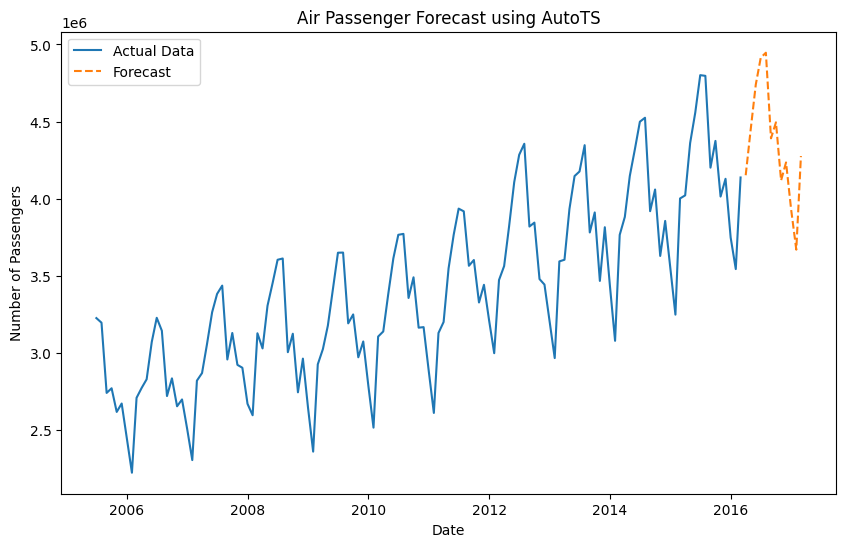

In [ ]:
!pip install autots pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from autots import AutoTS

file_path = 'Air.csv'
data = pd.read_csv(file_path)

print(data.head())


if 'Activity Period' not in data.columns or 'Passenger Count' not in data.columns:
    raise ValueError("The dataset does not contain required columns: 'Activity Period' and 'Passenger Count'")

data['Activity Period'] = pd.to_datetime(data['Activity Period'], format='%Y%m')
data = data.groupby('Activity Period')['Passenger Count'].sum().reset_index()

data.columns = ['Month', 'Passengers']


model = AutoTS(
    forecast_length=12,
    frequency='MS',
    ensemble='simple',
    model_list="default",
    max_generations=5,
    n_jobs='auto'
)

model = model.fit(data.reset_index(drop=True), date_col='Month', value_col='Passengers', id_col=None)

prediction = model.predict()
forecast = prediction.forecast

print("Best Model:", model.best_model['Model'])
print("Forecasted Values:\n", forecast)

plt.figure(figsize=(10, 6))
plt.plot(data['Month'], data['Passengers'], label="Actual Data")
plt.plot(forecast.index, forecast['Passengers'], label="Forecast", linestyle="--")
plt.title("Air Passenger Forecast using AutoTS")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()